In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler;
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import xgboost as xgb
from sklearn.metrics import r2_score
import datetime
import scienceplots
import os 
import re
import joblib
import random

In [2]:
save_directory = r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Results\Ronqueira'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

In [3]:
def clean_column_name(col):
    return re.sub('[^A-Za-z0-9]+', '_', col)

# Real Data import and treatment

In [4]:
data = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Ronqueira_10-07-2023\Sara\Ronqueira_adap.csv', index_col=False, delimiter=';')
#pump_granja= pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Ronqueira_10-07-2023\Sara\Aveleira_Bomba.csv', sep=";", index_col=False)
data.head()

,Time,PE_ALB,PE_AVL,PE_ESP,ALB_PE,ALB_AVL,ALB_ESP,PE_ARR_1,PE_SPD_1,PE_TRA,...,Res_Arr2,Res_Ave1,Res_Esp1,Res_Esp2,Res_SPD1,Res_SPD2,Res_Tra1,Res_Tra2,PE_Arr_balanco,PE_SPD_balanco
0,08/01/2023 00:00,54.803823,25.806933,6.575956,54.626148,22.837629,0.0,20.333890,0.000000,0.028963,...,4.070000,3.010742,2.64,2.695000,2.868298,2.886006,4.102800,4.102800,1.904747,0.000000
1,08/01/2023 00:15,54.027245,24.848133,6.882044,53.898630,39.561740,0.0,68.037148,10.146074,0.033333,...,4.070000,3.002896,2.64,2.695000,2.923875,2.938275,4.123692,4.125184,0.000000,32.495006
2,08/01/2023 00:30,52.989289,23.743866,7.522089,52.696259,42.188074,0.0,28.415630,93.223481,0.033333,...,4.087164,3.028325,2.64,2.695000,2.938518,2.967626,4.168308,4.171815,0.000000,21.821438
3,08/01/2023 00:45,51.910400,22.739644,7.739156,51.783111,42.184815,0.0,33.034407,126.466555,0.028852,...,4.130618,3.050512,2.64,2.680957,2.886003,2.948445,4.208374,4.207404,57.200227,14.352762
4,08/01/2023 01:00,51.260933,21.434267,7.833422,51.129667,42.117037,0.0,81.185223,123.660815,0.031148,...,4.145517,3.079488,2.64,2.652638,2.810266,2.889680,4.247470,4.241948,0.000000,0.000000


In [5]:
data['Time']= pd.to_datetime(data.Time,dayfirst=True)
#pump_granja['Time']= pd.to_datetime(pump_granja.Time,dayfirst=True)

In [6]:
data = data.drop_duplicates(subset='Time')
#pump_granja = pump_granja.drop_duplicates(subset='Time')

In [7]:
print('Data \n',data['Time'].describe())
#print('Pump_Granja \n',pump_granja['Time'].describe())

Data 
 count                   15018
unique                  15018
top       2023-01-08 00:00:00
freq                        1
first     2023-01-08 00:00:00
last      2023-07-13 00:00:00
Name: Time, dtype: object


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13076\4144665648.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print('Data \n',data['Time'].describe())


In [8]:
#pump_granja.head()

In [9]:
data.columns

Index(['Time', 'PE_ALB', 'PE_AVL', 'PE_ESP', 'ALB_PE', 'ALB_AVL', 'ALB_ESP',
       'PE_ARR_1', 'PE_SPD_1', 'PE_TRA', 'Pump_ALB_total', 'Pump_ALB1',
       'Pump_ALB2', 'Pump_Tra', 'Pump_ARR', 'Pump_SPD', 'Res_Alb1', 'Res_Alb2',
       'Res_Arr1', 'Res_Arr2', 'Res_Ave1', 'Res_Esp1', 'Res_Esp2', 'Res_SPD1',
       'Res_SPD2', 'Res_Tra1', 'Res_Tra2', 'PE_Arr_balanco', 'PE_SPD_balanco'],
      dtype='object')

Delete first 288 lines so that both dataframes begin in january 11 at 00:00


In [10]:
# nº of rows to drop
n = 288
data.drop(index=data.index[:n], axis=0, inplace = True)

Check if my dataframe is complete in time


In [11]:
#data['timestamp'] = pd.to_datetime(data['Time'])
## Determine the start and end times in your data
#start_time = data['timestamp'].min()
#end_time = data['timestamp'].max()
#
## Create a reference time series with 15-minute intervals
#complete_time_series = pd.date_range(start=start_time, end=end_time, freq='15T')
#
## Find the missing intervals by comparing the reference with your actual data
#missing_intervals = complete_time_series[~complete_time_series.isin(data['timestamp'])]
#
## If missing_intervals is empty, then your data is complete
#if missing_intervals.empty:
#    print("Your time data is complete.")
#else:
#    print("Data is incomplete. Missing intervals:")
#    print(missing_intervals)

## From january 11 to july 13, 15 min interval

Interpolation of pump_granja because of inconstant time stamps. Merge dataframes into one


In [12]:
#data.set_index('Time', inplace=True)
#pump_granja.set_index('Time', inplace=True)
## 4. Handle duplicates by averaging the values for each column while retaining the datetime nature of the index
#data = data.groupby('Time').mean()
#pump_granja = pump_granja.groupby('Time').mean()
#
## 5. Resample and interpolate the pump_granja dataframe
#pump_granja_resampled = pump_granja.resample('15T').interpolate(method='zero')
#
## 6. Merge the two dataframes
#merged_data = data.merge(pump_granja_resampled, left_index=True, right_index=True, how='left')
#
## 7. Reset the index
#merged_data.reset_index(inplace=True)

Rename all columns; eliminate ALB_AVL


In [13]:
data=data.drop(columns=['ALB_PE'])
#merged_data=merged_data.rename(columns={"Res_SPD1": "b'Res_SPDias'", "Res_Arr1" : "b'Res_OCastro'", "Res_Tra1" : "b'Res_Travanca'", "Res_Alb1" : "b'Res_Albarqueira'", "Res_Ave1" : "b'Res_Aveleira'", "Res_Esp1" : "b'Res_Espinheira'", "Pump_Tra" : "pumps_b'p_trav'", "Pump_SPD" : "pumps_b'p_spd'", "ALB_AVL" : "pumps_b'p_granja'", "Pump_ARR" : "pumps_b'p_out'", "Pump_ALB1" : "pumps_b'p_alb'", "Pump_ALB2" : "pumps_b'p_alb_2'", "PE_TRA" : "junction_b'10'", "PE_ARR_1" : "junction_b'11'", "PE_SPD_1" : "junction_b'12'", "PE_ALB" : "junction_b'15'", "PE_ESP" : "junction_b'18'", "PE_AVL" : "junction_b'20'", "PE_Arr_balanco" : "junction_b'2'", "PE_SPD_balanco" : "junction_b'6'"})
#merged_data=data.rename(columns={"Res_SPD1": "b'Res_SPDias'", "Res_Arr1" : "b'Res_OCastro'", "Res_Tra1" : "b'Res_Travanca'", "Res_Alb1" : "b'Res_Albarqueira'", "Res_Ave1" : "b'Res_Aveleira'", "Res_Esp1" : "b'Res_Espinheira'", "Pump_Tra" : "pumps_b'p_trav'", "Pump_SPD" : "pumps_b'p_spd'", "ALB_AVL" : "pumps_b'p_granja'", "Pump_ARR" : "pumps_b'p_out'", "Pump_ALB1" : "pumps_b'p_alb'", "Pump_ALB2" : "pumps_b'p_alb_2'", "PE_TRA" : "junction_b'10'", "PE_ARR_1" : "junction_b'11'", "PE_SPD_1" : "junction_b'12'", "PE_ALB" : "junction_b'15'", "PE_ESP" : "junction_b'18'", "PE_AVL" : "junction_b'20'", "PE_Arr_balanco" : "junction_b'2'", "PE_SPD_balanco" : "junction_b'6'"})

In [14]:
new_column_names = {
    "Res_SPD1": 'b_Res_SPD',
    "Res_Arr1": 'b_Res_OC',
    "Res_Tra1": 'b_Res_TRV',
    "Res_Alb1": 'b_Res_ALB',
    "Res_Ave1": 'b_Res_AVL',
    "Res_Esp1": 'b_Res_ESP',
    "Pump_Tra" : "pumps_b_p_trv",
    "Pump_SPD" : "pumps_b_p_spd",
    "ALB_AVL" : "pumps_b_p_grj",
    "Pump_ARR" : "pumps_b_p_oc",
    "Pump_ALB1" : "pumps_b_p_alb",
    "Pump_ALB2" : "pumps_b_p_alb2",
    "PE_TRA" : "junction_b'10'", 
    "PE_ARR_1" : "junction_b'11'",
    "PE_SPD_1" : "junction_b'12'",
    "PE_ALB" : "junction_b'15'", 
    "PE_ESP" : "junction_b'18'",
    "PE_AVL" : "junction_b'20'",
    "PE_Arr_balanco" : "junction_b'2'",
    "PE_SPD_balanco" : "junction_b'6'"
}

# Rename the columns
merged_data=data.rename(columns=new_column_names, inplace=False)

pump_state columns


In [15]:
# Iterate over the columns of the DataFrame
for col in merged_data.columns:
    # Check if the column name starts with "pumps_b"
    if col.startswith("pumps_b_p"):
        # Create a new column name based on the original column name
        new_col_name = "pump_state" + col.split("pumps", 1)[1]
        # Assign values to the new column based on the values in the original column
        merged_data[new_col_name] = merged_data[col].apply(lambda x: 1 if x != 0 else 0)

# Display the first few rows of the updated DataFrame
merged_data.columns

Index(['Time', 'junction_b'15'', 'junction_b'20'', 'junction_b'18'',
       'pumps_b_p_grj', 'ALB_ESP', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd'],
      dtype='object')

## Pumps power calculation through hydraulic and efficiency equations


### $P_{[kw]}= \frac{Q*\rho*g*h_{p}}{3.6*10^6 * \eta}$ 
$\rho = 1000 \space kg/m^3$


**Albarqueira:** 
<br>
    $h_{p} = 400.95-0.0009883x^{2.38}$ 
    <br>
    $\eta = -2*10^{-7}x^4 + 9*10^{-5}x^3 -0.0178x^2 + 1.8324x + 0.2924$
<br>
**Travanca:**
<br>
    $h_{p} = 258.96-0.006032*x^{2.20}$
    <br>
    $\eta = -0.0198x^{2} + 2.3979x + 5.0073$
<br>
**Outeiro (ARR):**
<br>
    $h_{p} = 262.05-9.376*10^{-11}x^{5.29}$
    <br>
    $\eta = 7*10^{-05}x^3 - 0.0232x^2 + 2.3762x + 0.156$
<br>
**São Pedro Dias (SPD)**
<br>
    $h_{p} = 390.07-0.001491x^{2.41}$
    <br>
    $\eta = 7*10^{-05}x^3 - 0.0232x^2 + 2.3762x + 0.156$
<br>
**Granja (Aveleira)**
<br>
    $h_{p} = 250.36-0.00469x^{2.42}$
    <br>
    $\eta = 0.0005x^3 - 0.0854x^2 + 4.454x + 0.2367$



In [16]:
rho = 1000; g = 9.81

In [17]:
merged_data["pump_kw_alb"] = merged_data["pumps_b_p_alb"].apply(lambda Q: (100*Q*rho*g*(400.95-0.0009883*(Q**2.38)))/((3.6*10**6)*((-2*10**-7)*(Q**4)+(9*10**-5)*(Q**3)-0.0178*(Q**2)+(1.8324*Q)+0.2924)))
#Albarqueira
merged_data["pump_kw_alb2"] = merged_data["pumps_b_p_alb2"].apply(lambda Q: (100*Q*rho*g*(400.95-0.0009883*(Q**2.38)))/((3.6*10**6)*((-2*10**-7)*(Q**4)+(9*10**-5)*(Q**3)-0.0178*(Q**2)+(1.8324*Q)+0.2924)))
#Travanca
merged_data["pump_kw_trv"] = merged_data["pumps_b_p_trv"].apply(lambda Q: (100*Q*rho*g*(258.96-0.006032*(Q**2.20)))/((3.6*10**6)*(-0.0198*(Q**2)+(2.3979*Q)+5.0073)))
# Outeiro (ARR)
merged_data["pump_kw_oc"] = merged_data["pumps_b_p_oc"].apply(lambda Q: (100*Q*rho*g*(262.05-(9.376*10**-11)*(Q**5.29)))/((3.6*10**6)*((7*10**-5)*(Q**3)-0.0232*(Q**2)+(2.3762*Q)+0.156)))
# São Pedro Dias (SPD)
merged_data["pump_kw_spd"] = merged_data["pumps_b_p_spd"].apply(lambda Q: (100*Q*rho*g*(390.07-0.001491*(Q**2.41)))/((3.6*10**6)*((7*10**-5)*(Q**3)-0.0232*(Q**2)+(2.3762*Q)+0.156)))
#Granja (Aveleira)
merged_data["pump_kw_grj"] = merged_data["pumps_b_p_grj"].apply(lambda Q: (100*Q*rho*g*(250.36-0.00469*(Q**2.42)))/((3.6*10**6)*(0.0005*(Q**3)-(0.0854*(Q**2))+(4.454*Q)+0.2367)))


Test eliminar residuais da bomba;
Altero o tanque da Albarqueira

In [18]:
#for i in merged_data.index[1:]:
#    if merged_data.loc[i, "pumps_b'p_alb'"] < 90:
#        merged_data.loc[i,"b'Res_Albarqueira'"]=merged_data.loc[i,"b'Res_Albarqueira'"] - merged_data.loc[i,"pumps_b'p_alb'"]/((np.pi*23.33**2)/4)

### Valve
Controls from EPANET. 
<br>
1-OPEN IF NODE Res_Espinheira BELOW 2.225 <br>
0-CLOSED IF NODE Res_Espinheira ABOVE 2.7 <br>
0-CLOSED IF NODE Res_Albarqueira_cel1 BELOW 2.54 <br>
0-CLOSED AT TIME 0.0

Definir valvula através do caudal ALB_ESP

In [19]:
# Iterate over the columns of the DataFrame
for col in merged_data.columns:
    # Check if the column name starts with "pumps_b"
    if col.startswith("ALB_ESP"):
        # Create a new column name based on the original column name
        new_col_name = "Valve"
        # Assign values to the new column based on the values in the original column
        merged_data[new_col_name] = merged_data[col].apply(lambda x: 1 if x != 0 else 0)

# Display the first few rows of the updated DataFrame
merged_data.columns

Index(['Time', 'junction_b'15'', 'junction_b'20'', 'junction_b'18'',
       'pumps_b_p_grj', 'ALB_ESP', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd', 'pump_kw_alb',
       'pump_kw_alb2', 'pump_kw_trv', 'pump_kw_oc', 'pump_kw_spd',
       'pump_kw_grj', 'Valve'],
      dtype='object')

Definir valvula através dos niveis

In [20]:
## Initialize the "Valve" column to 0 (CLOSED)
#merged_data['Valve'] = 0
#for t in merged_data.index[1:]:
#    prev_t = merged_data.index[list(merged_data.index).index(t) - 1]  # Find the previous index
#    if merged_data.loc[t, "b_Res_ESP"] < 2.25:
#        merged_data.loc[t, 'Valve'] = 1  # Open
#    elif merged_data.loc[t, "b_Res_ESP"] > 2.7:
#        merged_data.loc[t, 'Valve'] = 0  # Close
#    elif merged_data.loc[t, "b_Res_ALB"] < 2.54:
#        merged_data.loc[t, 'Valve'] = 0  # Close
#    elif merged_data.loc[t,"b_Res_ALB"]- merged_data.loc[prev_t,"b_Res_ALB"] > 0  and merged_data.loc[t,"b_Res_ESP"]- merged_data.loc[prev_t,"b_Res_ESP"] <=0: # Albarqueira a subir e Espinheira descer
#        merged_data.loc[t, 'Valve'] = 0 # Close
#    elif merged_data.loc[t,"b_Res_ALB"]- merged_data.loc[prev_t,"b_Res_ALB"] < 0  and merged_data.loc[t,"b_Res_ESP"]- merged_data.loc[prev_t,"b_Res_ESP"] >0: # Albarqueira a descer e Espinheira a subir
#        merged_data.loc[t, 'Valve'] = 1 # Open
#    else:
#        merged_data.loc[t, 'Valve'] = merged_data.loc[prev_t, 'Valve']

## Exponencial Smoothing

In [21]:
#for col in merged_data.columns:
#    if col.startswith("b'Res_"):
#        # Apply exponential smoothing
#        ex_S = ExponentialSmoothing(merged_data[col], seasonal='add', seasonal_periods=12)
#        smooth_fit = ex_S.fit()
#        
#        # Replace the original column with the smoothed data
#        merged_data[col] = smooth_fit.fittedvalues

pf=ExponentialSmoothing(merged_data.b_Res_ESP).fit(smoothing_level=0.45, optimized=False) # Para o reservatorio da Espinheira
pf1=ExponentialSmoothing(merged_data.b_Res_ALB).fit(smoothing_level=0.5)
#pf2=ExponentialSmoothing(merged_data.b_Res_OC).fit(smoothing_level=0.45)
merged_data["b_Res_ESP"][:-1]= pf.fittedvalues[1:]
merged_data["b_Res_ALB"][:-1]= pf1.fittedvalues[1:]
#merged_data["b_Res_OC"][:-1]= pf2.fittedvalues[1:]
print(len(merged_data["b_Res_ESP"]))
print(len(merged_data["b_Res_ALB"]))

14730
14730


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13076\2382312706.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data["b_Res_ESP"][:-1]= pf.fittedvalues[1:]
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_13076\2382312706.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveat

## Removing july 10th, once will be the cross testing day

In [22]:
date_to_remove = pd.to_datetime('2023-07-10')
#Save the day in a csv file
rows_to_remove = merged_data[merged_data['Time'].dt.date == date_to_remove.date()]
rows_to_remove.to_csv('Ronqueira_10_07.csv', index=False)
# Filter out rows corresponding to the date to be removed in df_filtered DataFrame
df_filtered = merged_data[merged_data['Time'].dt.date != date_to_remove.date()].copy()

### Tank Variation

In [23]:
# Calculate the time difference (dtime) in hours
df_filtered['dtime'] = df_filtered['Time'].diff(periods=-1).dt.total_seconds()

# Filter out columns that start with "b'Res_"
tank_level_columns = [col for col in df_filtered.columns if col.startswith("b_Res_")]

# Modify existing loop to include division by dtime (now in hours)
for col in tank_level_columns:
    delta_col_name = "Δ_" + col
    df_filtered[delta_col_name] = df_filtered[col].diff(periods=-1) / df_filtered['dtime']

# Show the first few rows of the updated DataFrame to verify the changes
#df_filtered.head()

eliminate the first and last values of when the pump turn on/off + the same for Valve


In [24]:
alb1_cond = ((df_filtered["pump_kw_alb"] < 125 - 7) | (df_filtered["pump_kw_alb"] > 125 + 5)) & (df_filtered["pump_kw_alb"] != 0)
alb2_cond = ((df_filtered["pump_kw_alb2"] <120 -1) | (df_filtered["pump_kw_alb2"] > 120 +2)) & (df_filtered["pump_kw_alb2"] != 0)
trav_cond = (df_filtered["pump_kw_trv"] < 40 - 3) & (df_filtered["pump_kw_trv"] != 0)
arr_cond = (df_filtered["pump_kw_oc"] < 90 - 2) & (df_filtered["pump_kw_oc"] != 0)
spd_cond = (df_filtered["pump_kw_spd"] < 79 - 3) & (df_filtered["pump_kw_spd"] != 0)
gran_cond = (df_filtered["pump_kw_grj"] < 31 - 3) & (df_filtered["pump_kw_grj"] != 0)
valv_cond = (df_filtered["ALB_ESP"] < 83) & (df_filtered["ALB_ESP"] != 0)

combined_conditions = alb1_cond | alb2_cond | trav_cond | arr_cond | spd_cond | gran_cond | valv_cond
df_filtered = df_filtered[~combined_conditions]
df_filtered.columns

Index(['Time', 'junction_b'15'', 'junction_b'20'', 'junction_b'18'',
       'pumps_b_p_grj', 'ALB_ESP', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd', 'pump_kw_alb',
       'pump_kw_alb2', 'pump_kw_trv', 'pump_kw_oc', 'pump_kw_spd',
       'pump_kw_grj', 'Valve', 'dtime', 'Δ_b_Res_ALB', 'Δ_b_Res_OC',
       'Δ_b_Res_AVL', 'Δ_b_Res_ESP', 'Δ_b_Res_SPD', 'Δ_b_Res_TRV'],
      dtype='object')

# Real data XGBOOST

In [25]:
df_filtered_sh = df_filtered.copy()

In [26]:
print(df_filtered_sh.isnull().sum().sum())  # If using pandas DataFrames
df_filtered_sh = df_filtered_sh.dropna()

57


In [27]:
df_filtered_sh.to_csv('real_samples_13nov.csv')

### Split

In [28]:
# SPLIT x and y
#in_col = [
#    "b'Res_Albarqueira'", "b'Res_Travanca'" , "b'Res_OCastro'", "b'Res_SPDias'", "b'Res_Aveleira'", "b'Res_Espinheira'",
#    "junction_b'10'", "junction_b'11'", "junction_b'12'", "junction_b'15'", "junction_b'18'", "junction_b'20'",
#    "junction_b'2'", "junction_b'6'", "p_state__alb'", "p_state__alb_2'", "p_state__trav'", "p_state__out'", 
#    "p_state__spd'", "p_state__granja'", "Valve"
#]
#X = df_filtered_sh.loc[:, in_col]
#out_col = ["pumps_kw_b'p_alb'", "pumps_kw_b'p_alb2'", "pumps_kw_b'p_trav'", "pumps_kw_b'p_out'", "pumps_kw_b'p_spd'", "pumps_kw_b'p_granja'",
#           "Δ_b'Res_Albarqueira'", "Δ_b'Res_Travanca'", "Δ_b'Res_OCastro'", "Δ_b'Res_SPDias'", "Δ_b'Res_Aveleira'", "Δ_b'Res_Espinheira'"
#]
#y = df_filtered_sh.loc[:, out_col]

With the 2 junctions that i hadn't in EPANET

In [29]:
in_col = [
    "b_Res_ALB", "b_Res_TRV" , "b_Res_OC", "b_Res_SPD", "b_Res_AVL", "b_Res_ESP",
    "junction_b'10'", "junction_b'11'", "junction_b'12'", "junction_b'15'", "junction_b'18'", "junction_b'20'",
    "junction_b'2'", "junction_b'6'", "pump_state_b_p_alb", "pump_state_b_p_alb2", "pump_state_b_p_trv", "pump_state_b_p_oc", 
    "pump_state_b_p_spd", "pump_state_b_p_grj", "Valve"
]


X = df_filtered_sh.loc[:, in_col]
out_col = ["pump_kw_alb", "pump_kw_alb2", "pump_kw_trv", "pump_kw_oc", "pump_kw_spd", "pump_kw_grj",
           "Δ_b_Res_ALB", "Δ_b_Res_TRV", "Δ_b_Res_OC", "Δ_b_Res_SPD", "Δ_b_Res_AVL", "Δ_b_Res_ESP"
           ]
y = df_filtered_sh.loc[:, out_col]

In [30]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((6500, 21), (903, 21))

Normalize

In [31]:
X_train_norm=X_train.copy()
y_train_norm=y_train.copy()
x_test_norm=X_test.copy()
y_test_norm=y_test.copy()
x_val_norm=X_val.copy()
y_val_norm=y_val.copy()


# Specify the columns you want to normalize
columns_to_normalize1 = [col for col in in_col if not col.startswith("pump_state_") | col.startswith("Valv")]


# Initialize the MinMaxScaler and normalize columns
scaler_in = MinMaxScaler()
scaler_out = MinMaxScaler()

# For train
X_train_norm[columns_to_normalize1] = scaler_in.fit_transform(X_train[columns_to_normalize1])
y_train_norm[out_col] = scaler_out.fit_transform(y_train[out_col])

# For test
x_test_norm[columns_to_normalize1] = scaler_in.transform(X_test[columns_to_normalize1])
y_test_norm[out_col] = scaler_out.transform(y_test[out_col])
# For val
x_val_norm[columns_to_normalize1] = scaler_in.transform(X_val[columns_to_normalize1])
y_val_norm[out_col] = scaler_out.transform(y_val[out_col])

In [32]:
print('\n',scaler_in.feature_names_in_)
print('\n', scaler_out.feature_names_in_)


 ['b_Res_ALB' 'b_Res_TRV' 'b_Res_OC' 'b_Res_SPD' 'b_Res_AVL' 'b_Res_ESP'
 "junction_b'10'" "junction_b'11'" "junction_b'12'" "junction_b'15'"
 "junction_b'18'" "junction_b'20'" "junction_b'2'" "junction_b'6'"]

 ['pump_kw_alb' 'pump_kw_alb2' 'pump_kw_trv' 'pump_kw_oc' 'pump_kw_spd'
 'pump_kw_grj' 'Δ_b_Res_ALB' 'Δ_b_Res_TRV' 'Δ_b_Res_OC' 'Δ_b_Res_SPD'
 'Δ_b_Res_AVL' 'Δ_b_Res_ESP']


### Fitting the model and predicting

In [33]:
model = xgb.XGBRegressor(learning_rate=0.05,max_depth=20,n_estimators=250,eval_metric="rmse")
# model fit 
# Use normalized data!!!
model.fit(X_train_norm, y_train_norm, eval_set=[(X_train_norm, y_train_norm),(x_val_norm,y_val_norm)],early_stopping_rounds=10)

y_pred = model.predict(x_test_norm) # prediction

[0]	validation_0-rmse:0.38292	validation_1-rmse:0.38278


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:0.36386	validation_1-rmse:0.36376
[2]	validation_0-rmse:0.34575	validation_1-rmse:0.34570
[3]	validation_0-rmse:0.32855	validation_1-rmse:0.32854
[4]	validation_0-rmse:0.31221	validation_1-rmse:0.31225
[5]	validation_0-rmse:0.29669	validation_1-rmse:0.29677
[6]	validation_0-rmse:0.28194	validation_1-rmse:0.28208
[7]	validation_0-rmse:0.26793	validation_1-rmse:0.26813


[8]	validation_0-rmse:0.25462	validation_1-rmse:0.25488
[9]	validation_0-rmse:0.24199	validation_1-rmse:0.24231
[10]	validation_0-rmse:0.22998	validation_1-rmse:0.23036
[11]	validation_0-rmse:0.21857	validation_1-rmse:0.21902
[12]	validation_0-rmse:0.20773	validation_1-rmse:0.20826
[13]	validation_0-rmse:0.19744	validation_1-rmse:0.19803
[14]	validation_0-rmse:0.18766	validation_1-rmse:0.18833
[15]	validation_0-rmse:0.17837	validation_1-rmse:0.17912
[16]	validation_0-rmse:0.16955	validation_1-rmse:0.17038
[17]	validation_0-rmse:0.16117	validation_1-rmse:0.16209
[18]	validation_0-rmse:0.15320	validation_1-rmse:0.15423
[19]	validation_0-rmse:0.14564	validation_1-rmse:0.14677
[20]	validation_0-rmse:0.13845	validation_1-rmse:0.13969
[21]	validation_0-rmse:0.13163	validation_1-rmse:0.13298
[22]	validation_0-rmse:0.12514	validation_1-rmse:0.12662
[23]	validation_0-rmse:0.11899	validation_1-rmse:0.12060
[24]	validation_0-rmse:0.11314	validation_1-rmse:0.11488
[25]	validation_0-rmse:0.10757	va

In [34]:
joblib.dump(model, 'Ronqueira_real_model_13nov.joblib')
joblib.dump(scaler_in, 'Ronqueira_scaler_in_13nov.joblib')
joblib.dump(scaler_out, 'Ronqueira_scaler_out_13nov.joblib')

X_train_norm.to_csv(r'Results/Ronqueira/X_train_norm_13nov.csv')
y_train_norm.to_csv(r'Results/Ronqueira/y_train_norm_13nov.csv')
x_val_norm.to_csv(r'Results/Ronqueira/x_val_norm_13nov.csv')
y_val_norm.to_csv(r'Results/Ronqueira/y_val_norm_13nov.csv')
x_test_norm.to_csv(r'Results/Ronqueira/x_test_norm_13nov.csv')
y_test_norm.to_csv(r'Results/Ronqueira/y_test_norm_13nov.csv')

dict_keys(['validation_0', 'validation_1'])


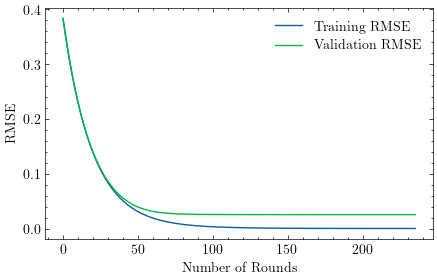

In [35]:
print(model.evals_result_.keys())
with plt.style.context('science'):
    plt.plot(model.evals_result_['validation_0']['rmse'], label='Training RMSE')
    plt.plot(model.evals_result_['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Number of Rounds')
    plt.ylabel('RMSE')
    #plt.title('XGBoost Learning Curve trained on Real data')
    plt.gcf().set_size_inches(5,3)
    plt.legend()
    plt.savefig(os.path.join(save_directory, "XGBoost_Loss_Real.pdf"), dpi=300)
    plt.show()

In [36]:
y_pred_df = pd.DataFrame(data=y_pred, columns=y_test.columns)

In [37]:
inverse_pred = pd.DataFrame(scaler_out.inverse_transform(y_pred_df[out_col]), columns=out_col)

### Metrics on Train

In [38]:
rmse_dict = {}

for column in y_test.columns:
    rmse = np.sqrt(mean_squared_error(y_test[column],inverse_pred[column]))
    rmse_dict[column] = rmse

mse_dict = {}
for column in y_test.columns:
    mse = mean_squared_error(y_test[column],inverse_pred[column])
    mse_dict[column] = mse
    
r2_dict = {}
for column in y_test.columns:
    r2 = r2_score(y_test[column],inverse_pred[column])
    r2_dict[column] = r2
    
    
    
metrics_xgboost = pd.DataFrame({'RMSE': rmse_dict, 'MSE': mse_dict, 'R2': r2_dict})

print('Metrics - trained on real dataset \n',metrics_xgboost)

Metrics - trained on real dataset 
                   RMSE           MSE        R2
pump_kw_alb   0.608778  3.706108e-01  0.999791
pump_kw_alb2  0.106153  1.126838e-02  0.999990
pump_kw_trv   0.212747  4.526134e-02  0.999888
pump_kw_oc    0.372901  1.390552e-01  0.999933
pump_kw_spd   0.541462  2.931815e-01  0.999763
pump_kw_grj   0.371637  1.381143e-01  0.999383
Δ_b_Res_ALB   0.000008  7.206735e-11  0.954105
Δ_b_Res_TRV   0.000007  4.464102e-11  0.975946
Δ_b_Res_OC    0.000025  6.371205e-10  0.854172
Δ_b_Res_SPD   0.000005  2.561217e-11  0.993465
Δ_b_Res_AVL   0.000007  4.600149e-11  0.948847
Δ_b_Res_ESP   0.000005  2.133621e-11  0.910005


In [39]:
## Identify columns corresponding to pumps and tanks
#p_columns = [col for col in y_test.columns if "pumps_kw" in col]
#t_columns = [col for col in y_test.columns if "Δ" in col]
#
## Aggregate ground truth and predictions for pumps and tanks
#y_test_pump = y_test[p_columns].values.flatten()
#y_pred_pump = inverse_pred[p_columns].values.flatten()
#y_test_tank = y_test[t_columns].values.flatten()
#y_pred_tank = inverse_pred[t_columns].values.flatten()
#
## Compute global metrics
#global_metrics = {
#    'Metric': ['RMSE', 'MSE', 'R2'],
#    'Pump': [
#        np.sqrt(mean_squared_error(y_test_pump, y_pred_pump)),
#        mean_squared_error(y_test_pump, y_pred_pump),
#        r2_score(y_test_pump, y_pred_pump)
#    ],
#    'Tank': [
#        np.sqrt(mean_squared_error(y_test_tank, y_pred_tank)),
#        mean_squared_error(y_test_tank, y_pred_tank),
#        r2_score(y_test_tank, y_pred_tank)
#    ]
#}
#
#global_metrics_df = pd.DataFrame(global_metrics)
#
#
#print("Global Metrics Real:")
#print(global_metrics_df)

## Cross Testing

In [40]:
july_10 = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Ronqueira_10_07.csv', index_col=False)
print(july_10.head())

                  Time  junction_b'15'  junction_b'20'  junction_b'18'  \
0  2023-07-10 00:00:00       62.873422       20.318533        7.347511   
1  2023-07-10 00:15:00       61.885156       18.142267        6.464667   
2  2023-07-10 00:30:00       61.125555       16.846356        6.070000   
3  2023-07-10 00:45:00       60.147067       16.222133        5.790889   
4  2023-07-10 01:00:00       59.070178       15.996978        5.978444   

   pumps_b_p_grj  ALB_ESP  junction_b'11'  junction_b'12'  junction_b'10'  \
0            0.0      0.0        0.115518             0.0       10.750852   
1            0.0      0.0       59.752888             0.0       83.686223   
2            0.0      0.0       82.487555             0.0      112.908667   
3            0.0      0.0       26.121963             0.0      106.466482   
4            0.0      0.0        0.124259             0.0       99.749667   

   Pump_ALB_total  ...  pump_state_b_p_trv  pump_state_b_p_oc  \
0      132.471111  ...     

**total power original data**

In [41]:
# somatorio da potencia de todas as bombas naquele time step
july_10["total_pumps_kw"] = 0
for col in july_10.columns:
    if col.startswith("pumps_kw_b'p"):
        july_10["total_pumps_kw"] += july_10[col]
print(july_10.total_pumps_kw)

0     0
1     0
2     0
3     0
4     0
     ..
91    0
92    0
93    0
94    0
95    0
Name: total_pumps_kw, Length: 96, dtype: int64


In [42]:
july_10.columns

Index(['Time', 'junction_b'15'', 'junction_b'20'', 'junction_b'18'',
       'pumps_b_p_grj', 'ALB_ESP', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd', 'pump_kw_alb',
       'pump_kw_alb2', 'pump_kw_trv', 'pump_kw_oc', 'pump_kw_spd',
       'pump_kw_grj', 'Valve', 'total_pumps_kw'],
      dtype='object')

Final tank creation

In [43]:
for col in july_10.columns:
    if col.startswith("b_Res_"):
        # Shift the column values up by 1 row
        shifted_col = july_10[col].shift(-1)
        
        # Create a new column with the shifted values
        new_col_name = 'final_' + col
        july_10[new_col_name] = shifted_col

Seperating the time value for integration

In [44]:
# Convert 'Time' column to datetime format, if not already
july_10['Time'] = pd.to_datetime(july_10['Time'])

# Extract just the time component from the 'Time' column
july_10['Time_only'] = july_10['Time'].dt.time

july_10['dtime'] = july_10['Time'].diff().shift(-1)

# Convert the time difference to hours
july_10['dtime_h'] = july_10['dtime'].dt.total_seconds() / 3600
july_10['dtime_sec'] = july_10['dtime'].dt.total_seconds()


In [45]:
july_10.to_csv('july_10_treated_13nov.csv')

### Split X and y cross testing 

In [46]:
# SPLIT x and y
cross_in_col = [
    "b_Res_ALB", "b_Res_TRV" , "b_Res_OC", "b_Res_SPD", "b_Res_AVL", "b_Res_ESP",
    "junction_b'10'", "junction_b'11'", "junction_b'12'", "junction_b'15'", "junction_b'18'", "junction_b'20'",
    "junction_b'2'", "junction_b'6'", "pump_state_b_p_alb", "pump_state_b_p_alb2", "pump_state_b_p_trv", "pump_state_b_p_oc", 
    "pump_state_b_p_spd", "pump_state_b_p_grj", "Valve"
]

cross_X = july_10.loc[:, cross_in_col]

cross_out_col = ["pump_kw_alb", "pump_kw_alb2", "pump_kw_trv", "pump_kw_oc", "pump_kw_spd", "pump_kw_grj",
           "Δ_b_Res_ALB", "Δ_b_Res_TRV", "Δ_b_Res_OC", "Δ_b_Res_SPD", "Δ_b_Res_AVL", "Δ_b_Res_ESP"
]




Initial level dataframe

In [47]:
tank_columns = [col for col in cross_X.columns if col.startswith("b_Res_")]
# Create a new dataframe with only the first value of each 'tank_0' column
init_level = pd.DataFrame()
for col in tank_columns:
    init_level[col] = [july_10['final_'+col].iloc[0]]

# Print the 'init_level' dataframe
print(init_level)

   b_Res_ALB  b_Res_TRV  b_Res_OC  b_Res_SPD  b_Res_AVL  b_Res_ESP
0   3.216112   4.409446  4.216043   3.051024   3.762107   2.644969


In [48]:
pump_columns = [col for col in july_10.columns if col.startswith("pump_kw_")]

In [49]:
new_x = cross_X.drop(columns=tank_columns + ['Valve'])

In [50]:
#july_10.drop(july_10.index[-1], inplace=True)

### Making predictions - For cross testing

In [51]:
tank_final = pd.DataFrame()
potencia = pd.DataFrame()
tank_0 = pd.DataFrame()
df_real_cross = pd.DataFrame()
model_input = pd.DataFrame()
y_pred_cross_un=pd.DataFrame()

final = pd.DataFrame(0,index=[0], columns=[tank_columns]) # inicializar dataframe com indice
power = pd.DataFrame(0,index=[0], columns=[pump_columns]) 
flag_first_time = True
Valvula = [0]
for i in range(len(july_10['Time_only'])):
    dtime = july_10['dtime_sec'][i]
    if july_10['Time_only'][i] == datetime.time(0, 0) and flag_first_time:
        flag_first_time=False
        final = init_level.copy()
        power = pd.DataFrame(july_10[pump_columns].iloc[[0]], index=[0], columns=pump_columns)
    else:
        tank_0 = tank_final.iloc[[-1]]
        new_row=new_x.iloc[[i]]
        x_test_cross = pd.concat([tank_0.reset_index(drop=True), new_row.reset_index(drop=True)], axis=1)
        
        # Definição valvula
        for t in range(len(x_test_cross)):
            if x_test_cross.loc[t, "b_Res_ESP"] < 2.25:
                valve_value = 1  # Open
            elif x_test_cross.loc[t, "b_Res_ESP"] > 2.7:
                valve_value = 0  # Close
            elif x_test_cross.loc[t, "b_Res_ALB"] < 2.54:
                valve_value = 0  # Close
            else:
                valve_value = Valvula[-1]
        
            x_test_cross['Valve'] = valve_value
            Valvula.append(valve_value)
        
        # Normalization
        x_normalizado = x_test_cross.copy()
        model_input=x_normalizado.copy() # Apenas para criar o dataframe com tudo
        x_normalizado[columns_to_normalize1] = scaler_in.transform(x_normalizado[columns_to_normalize1])
        # Prediction
        y_pred_cross = model.predict(x_normalizado)
        y_pred_cross_df = pd.DataFrame(data=y_pred_cross, columns=[cross_out_col])
        
        # Desnormalizar
        y_pred_cross_un = pd.DataFrame(scaler_out.inverse_transform(y_pred_cross_df[cross_out_col]), columns=[cross_out_col])
        # Integration


        for j in tank_columns:
            final[j] = (y_pred_cross_un['Δ_' + j].values * dtime) + tank_0[j].values[0]
        for h in pump_columns:
            power[h] = y_pred_cross_un[h]

    tank_final = pd.concat([tank_final, final], ignore_index=True)
    potencia = pd.concat([potencia, power], ignore_index=True)
    df_real_cross = pd.concat([df_real_cross, pd.Series([dtime], name='dtime'),
    pd.Series([july_10['Time_only'][i]], name='epanet_time'), model_input, final, y_pred_cross_un,], ignore_index=True)


print('intit level', init_level)
print('tank final', tank_final.head(3))
#print(tank_final.shape)
#print(potencia.shape)
df_real_cross.to_csv(save_directory+'\df_real_cross_13nov.csv')


intit level    b_Res_ALB  b_Res_TRV  b_Res_OC  b_Res_SPD  b_Res_AVL  b_Res_ESP
0   3.216112   4.409446  4.216043   3.051024   3.762107   2.644969
tank final    b_Res_ALB  b_Res_TRV  b_Res_OC  b_Res_SPD  b_Res_AVL  b_Res_ESP
0   3.216112   4.409446  4.216043   3.051024   3.762107   2.644969
1   3.251581   4.381161  4.232735   3.093689   3.737051   2.644188
2   3.287879   4.324356  4.236649   3.134224   3.714144   2.642042


In [52]:
df_real_cross.to_csv(save_directory+'\df_real_cross_13nov.csv')
tank_final.to_csv('pred_tank_final_13nov.csv')

Plots

In [53]:
time_list = list(range(0, 86400, 900))
time_list_hours = [t / 3600 for t in time_list]
#time_list_hours = time_list_hours[1:-1]

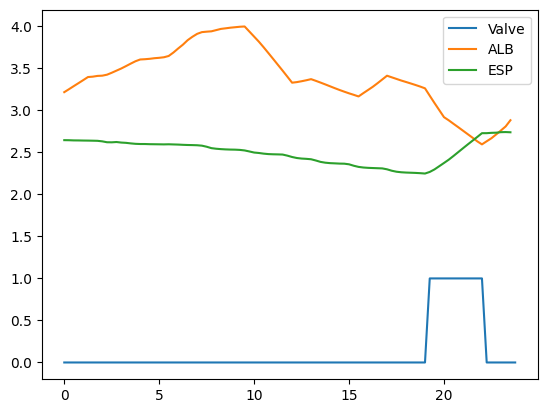

In [54]:
plt.plot(time_list_hours,Valvula, label = 'Valve')
plt.plot(time_list_hours,tank_final['b_Res_ALB'],label = 'ALB')
plt.plot(time_list_hours,tank_final['b_Res_ESP'], label='ESP')
plt.legend()
plt.show()

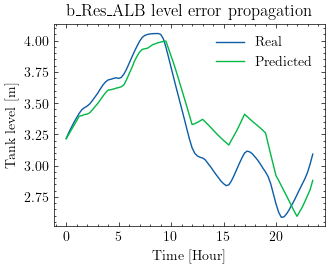

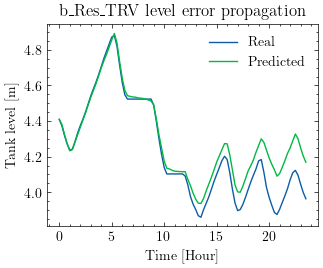

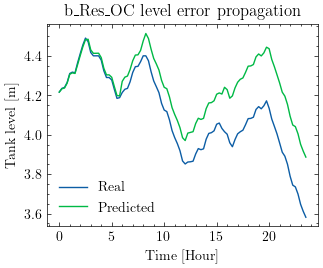

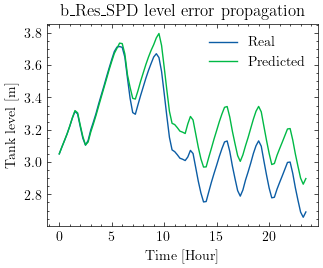

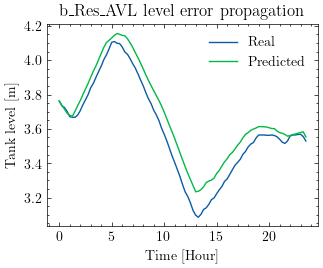

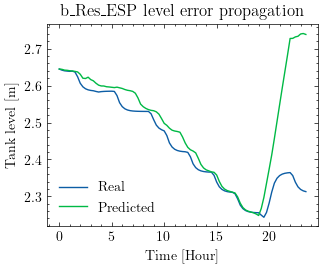

In [55]:
for m in tank_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10['final_' + str(m)], label='Real')
        plt.plot(time_list_hours, tank_final[m], label='Predicted')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Tank level [m]')
        plt.title('{} level error propagation'.format(m))
        plt.savefig(os.path.join(save_directory, 'ron_' + clean_column_name(m) + " level error propagation.pdf"), dpi=300)
        plt.show()

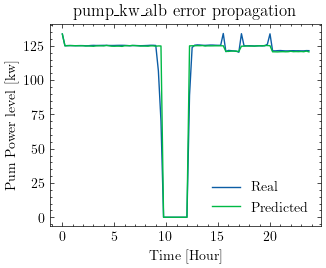

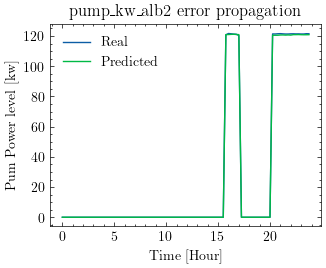

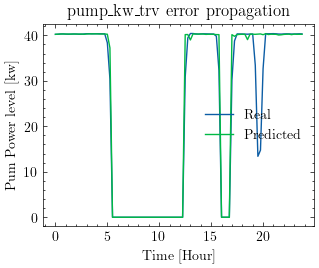

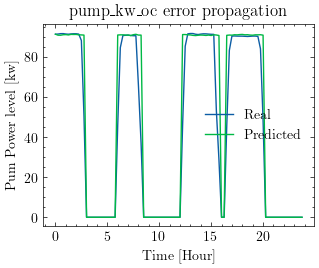

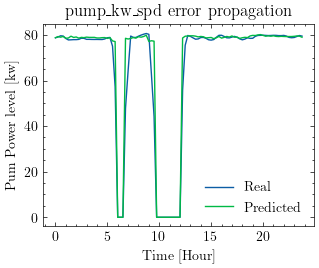

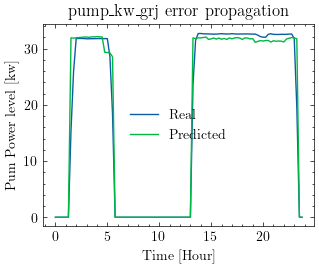

In [56]:
for j in pump_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10[j], label='Real')
        plt.plot(time_list_hours, potencia[j], label='Predicted')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Pum Power level [kw]')
        plt.title('{}  error propagation'.format(j))
        plt.savefig(os.path.join(save_directory, 'ron_' + clean_column_name(j) + " error propagation.pdf"), dpi=300)

        plt.show()

In [57]:
tank_final_nan=tank_final.dropna()
july_10_nan = july_10.dropna()
potencia_nan=potencia[:-1]

## Metrics on Cross Testing

In [58]:
july_10.columns

Index(['Time', 'junction_b'15'', 'junction_b'20'', 'junction_b'18'',
       'pumps_b_p_grj', 'ALB_ESP', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd', 'pump_kw_alb',
       'pump_kw_alb2', 'pump_kw_trv', 'pump_kw_oc', 'pump_kw_spd',
       'pump_kw_grj', 'Valve', 'total_pumps_kw', 'final_b_Res_ALB',
       'final_b_Res_OC', 'final_b_Res_AVL', 'final_b_Res_ESP',
       'final_b_Res_SPD', 'final_b_Res_TRV', 'Time_only', 'dtime', 'dtime_h',
       'dtime_sec'],
      dtype='object')

In [59]:
july_10 = july_10[["Time", "junction_b'15'", "junction_b'20'", "junction_b'18'",
       "pumps_b_p_grj", "junction_b'11'", "junction_b'12'", "junction_b'10'",
       "Pump_ALB_total", "pumps_b_p_alb", "pumps_b_p_alb2", "pumps_b_p_trv",
       "pumps_b_p_oc", "pumps_b_p_spd", "b_Res_ALB", "Res_Alb2", "b_Res_OC",
       "Res_Arr2", "b_Res_AVL", "b_Res_ESP", "Res_Esp2", "b_Res_SPD",
       "Res_SPD2", "b_Res_TRV", "Res_Tra2", "junction_b'2'", "junction_b'6'",
       "pump_state_b_p_grj", "pump_state_b_p_alb", "pump_state_b_p_alb2",
       "pump_state_b_p_trv", "pump_state_b_p_oc", "pump_state_b_p_spd",
       "pump_kw_alb", "pump_kw_alb2", "pump_kw_trv", "pump_kw_oc",
       "pump_kw_spd", "pump_kw_grj", "Valve", "total_pumps_kw",
       "final_b_Res_ALB", "final_b_Res_TRV", "final_b_Res_OC", "final_b_Res_SPD", "final_b_Res_AVL",
       "final_b_Res_ESP",  "Time_only",
       "dtime", "dtime_h", "dtime_sec"]]


In [60]:
potencia.to_csv('potencia_real_result.csv')
tank_final.to_csv('final_tank_real_result.csv')

In [61]:
r2_dict2_pumps = {}
rmse_dict2_pumps = {}
mse_dict2_pumps = {}

for column in pump_columns:
    r22_p = r2_score(july_10_nan[column],potencia_nan[column])
    rmse2_p = np.sqrt(mean_squared_error(july_10_nan[column], potencia_nan[column]))
    mse2_p = mean_squared_error(july_10_nan[column], potencia_nan[column])
    
    r2_dict2_pumps[column] = r22_p
    rmse_dict2_pumps[column] = rmse2_p
    mse_dict2_pumps[column] = mse2_p

# Tanks
r2_dict2_tanks = {}
rmse_dict2_tanks = {}
mse_dict2_tanks = {}
for column in tank_columns:
    r22_t = r2_score(july_10_nan['final_'+str(column)], tank_final_nan[column])
    rmse2_t = np.sqrt(mean_squared_error(july_10_nan['final_'+str(column)], tank_final_nan[column]))
    mse2_t = mean_squared_error(july_10_nan['final_'+str(column)], tank_final_nan[column])
    
    r2_dict2_tanks[column] = r22_t
    rmse_dict2_tanks[column] = rmse2_t
    mse_dict2_tanks[column] = mse2_t

# Create separate DataFrames for pumps and tanks
metrics_cross_pumps = pd.DataFrame({'RMSE': rmse_dict2_pumps, 'MSE': mse_dict2_pumps, 'R2': r2_dict2_pumps })
metrics_cross_tanks = pd.DataFrame({'RMSE': rmse_dict2_tanks, 'MSE': mse_dict2_tanks, 'R2': r2_dict2_tanks })

print(metrics_cross_pumps)
print(metrics_cross_tanks)

                   RMSE         MSE        R2
pump_kw_alb    7.174001   51.466291  0.965418
pump_kw_alb2   0.291565    0.085010  0.999965
pump_kw_trv    4.328717   18.737789  0.946412
pump_kw_oc    14.005773  196.161688  0.894612
pump_kw_spd    6.005054   36.060668  0.951185
pump_kw_grj    2.662778    7.090385  0.970453
               RMSE       MSE        R2
b_Res_ALB  0.197882  0.039157  0.796578
b_Res_TRV  0.098552  0.009713  0.873458
b_Res_OC   0.180907  0.032727  0.253007
b_Res_SPD  0.160147  0.025647  0.680262
b_Res_AVL  0.091107  0.008300  0.891825
b_Res_ESP  0.126530  0.016010 -0.019424


In [62]:
global_pumps_real = metrics_cross_pumps.mean()
global_tanks_real = metrics_cross_tanks.mean()
print('Global for pumps \n', global_pumps_real)
print('Global for tanks\n ', global_tanks_real)

Global for pumps 
 RMSE     5.744648
MSE     51.600305
R2       0.954674
dtype: float64
Global for tanks
  RMSE    0.142521
MSE     0.021926
R2      0.579284
dtype: float64


# Synthtic Training

Since the model had a "bad" performance by training only in the real data, synthtic data is generated in order to train the model. Then, the model will be retrained in the ral ones, and evaluated its performance. 

In [39]:
st_data = pd.read_csv(r'C:\Users\LENOVO\OneDrive - Universidade de Aveiro\universidade\Mestrado\2º Ano\Tese\Códigos\Test_epanet\Samples\Ronqueira_10-07-2023\Ronqueira_dynamic_simulation_v30_10_15min.csv', index_col=False)

In [40]:
st_data.describe()

,t_step,b'Res_SPDias',b'Res_OCastro',b'Res_Travanca',b'Res_Albarqueira_cel1',b'Res_Aveleira',b'Res_Espinheira',pumps_b'p_trav',pumps_b'p_spd',pumps_b'p_granja',...,final_b'Res_Albarqueira_cel1',final_b'Res_Aveleira',final_b'Res_Espinheira',valve_0,Δ_b'Res_SPDias',Δ_b'Res_OCastro',Δ_b'Res_Travanca',Δ_b'Res_Albarqueira_cel1',Δ_b'Res_Aveleira',Δ_b'Res_Espinheira'
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,847.425700,5.988462,3.714144,4.248546,3.242735,3.147616,2.349337,0.501167,0.496000,0.494833,...,3.219371,3.139846,2.368442,0.498667,-0.000060,-0.000023,-0.000031,-0.000029,-0.000009,0.000023
std,169.696159,2.314595,0.457415,0.434086,0.721509,0.647255,0.201649,0.500007,0.499992,0.499982,...,0.722681,0.647599,0.202205,0.500007,0.000051,0.000034,0.000040,0.000076,0.000030,0.000029
min,2.000000,2.000000,2.920000,3.500000,2.000100,2.020000,2.000100,0.000000,0.000000,0.000000,...,1.999900,2.020000,2.000000,0.000000,-0.000178,-0.000100,-0.000114,-0.000211,-0.000062,-0.000012
25%,900.000000,3.983250,3.320200,3.875800,2.614900,2.587575,2.174400,0.000000,0.000000,0.000000,...,2.592275,2.581275,2.194875,0.000000,-0.000096,-0.000050,-0.000059,-0.000080,-0.000036,-0.000006
50%,900.000000,5.995200,3.712700,4.249000,3.242900,3.148650,2.348900,1.000000,0.000000,0.000000,...,3.218800,3.142100,2.368200,0.000000,-0.000059,-0.000023,-0.000031,-0.000027,-0.000016,-0.000003
75%,900.000000,7.986925,4.111425,4.625600,3.867900,3.713800,2.522825,1.000000,1.000000,1.000000,...,3.848100,3.707125,2.543825,1.000000,-0.000023,0.000004,-0.000004,0.000026,0.000018,0.000052
max,900.000000,9.999900,4.509900,4.999600,4.499600,4.260000,2.700000,1.000000,1.000000,1.000000,...,4.500000,4.260000,2.700000,1.000000,0.000059,0.000067,0.000050,0.000164,0.000056,0.000100


In [65]:
st_data.columns

Index(['t_step', 'b'Res_SPDias'', 'b'Res_OCastro'', 'b'Res_Travanca'',
       'b'Res_Albarqueira_cel1'', 'b'Res_Aveleira'', 'b'Res_Espinheira'',
       'pumps_b'p_trav'', 'pumps_b'p_spd'', 'pumps_b'p_granja'',
       'pumps_b'p_out'', 'pumps_b'p_alb_2'', 'pumps_b'p_alb'',
       'pumps_kw_b'p_trav'', 'pumps_kw_b'p_spd'', 'pumps_kw_b'p_granja'',
       'pumps_kw_b'p_out'', 'pumps_kw_b'p_alb_2'', 'pumps_kw_b'p_alb'',
       'junction_b'10'', 'junction_b'11'', 'junction_b'12'', 'junction_b'15'',
       'junction_b'18'', 'junction_b'20'', 'junction_b'2'', 'junction_b'6'',
       'final_b'Res_SPDias'', 'final_b'Res_OCastro'', 'final_b'Res_Travanca'',
       'final_b'Res_Albarqueira_cel1'', 'final_b'Res_Aveleira'',
       'final_b'Res_Espinheira'', 'valve_0', 'Δ_b'Res_SPDias'',
       'Δ_b'Res_OCastro'', 'Δ_b'Res_Travanca'', 'Δ_b'Res_Albarqueira_cel1'',
       'Δ_b'Res_Aveleira'', 'Δ_b'Res_Espinheira''],
      dtype='object')

Rename columns

In [66]:
#st_data=st_data.rename(columns={"b'Res_Albarqueira_cel1'": "b'Res_Albarqueira'", "pumps_b'p_trav'": "p_state__trav'" , "pumps_b'p_spd'": "p_state__spd'" , "pumps_b'p_granja'" : "p_state__granja'",
#       "pumps_b'p_out'" : "p_state__out'", "pumps_b'p_alb_2'" : "p_state__alb_2'", "pumps_b'p_alb'" : "p_state__alb'", "pumps_kw_b'p_alb_2'" : "pumps_kw_b'p_alb2'", "Δ_b'Res_Albarqueira_cel1'": "Δ_b'Res_Albarqueira'"})

In [41]:
new_column_names = {
    "b'Res_SPDias'": 'b_Res_SPD',
    "b'Res_OCastro'": 'b_Res_OC',
    "b'Res_Travanca'": 'b_Res_TRV',
    "b'Res_Albarqueira_cel1'": 'b_Res_ALB',
    "b'Res_Aveleira'": 'b_Res_AVL',
    "b'Res_Espinheira'": 'b_Res_ESP',
    "final_b'Res_SPDias'": 'final_b_final_Res_SPD',
    "final_b'Res_OCastro'": 'final_b_Res_OC',
    "final_b'Res_Travanca'": 'final_b_Res_TRV',
    "final_b'Res_Albarqueira_cel1'": 'final_b_Res_ALB',
    "final_b'Res_Aveleira'": 'final_b_Res_AVL',
    "final_b'Res_Espinheira'": 'final_b_Res_ESP',
    "pumps_b'p_trav'": 'pump_state_b_p_trv',
    "pumps_b'p_spd'": 'pump_state_b_p_spd',
    "pumps_b'p_granja'": 'pump_state_b_p_grj',
    "pumps_b'p_out'": 'pump_state_b_p_oc',
    "pumps_b'p_alb_2'": 'pump_state_b_p_alb2',
    "pumps_b'p_alb'": 'pump_state_b_p_alb',
    "pumps_kw_b'p_trav'": 'pump_kw_trv',
    "pumps_kw_b'p_spd'": 'pump_kw_spd',
    "pumps_kw_b'p_granja'": 'pump_kw_grj',
    "pumps_kw_b'p_out'": 'pump_kw_oc',
    "pumps_kw_b'p_alb_2'": 'pump_kw_alb2',
    "pumps_kw_b'p_alb'": 'pump_kw_alb',
    "Δ_b'Res_Albarqueira_cel1'": "Δ_b_Res_ALB",
    "Δ_b'Res_SPDias'": "Δ_b_Res_SPD",
    "Δ_b'Res_OCastro'":"Δ_b_Res_OC", 
    "Δ_b'Res_Travanca'":"Δ_b_Res_TRV",
    "Δ_b'Res_Aveleira'":"Δ_b_Res_AVL", 
    "Δ_b'Res_Espinheira'":"Δ_b_Res_ESP",
    "valve_0" :"Valve"
}

# Rename the columns
st_data.rename(columns=new_column_names, inplace=True)

 Valve
Controls from EPANET. 
<br>
1-OPEN IF NODE Res_Espinheira BELOW 2.225 <br>
0-CLOSED IF NODE Res_Espinheira ABOVE 2.7 <br>
0-CLOSED IF NODE Res_Albarqueira_cel1 BELOW 2.54 <br>
0-CLOSED AT TIME 0.0

In [68]:
## Initialize the "Valve" column to 0 (CLOSED)
#st_data['Valve'] = 0
#
## Apply the Open Condition
#open_condition = st_data["b'Res_Espinheira'"] < 2.25
#st_data.loc[open_condition, 'Valve'] = 1
## Apply the Closed Conditions
#closed_condition1 = st_data["b'Res_Espinheira'"] > 2.7
#closed_condition2 = st_data["b'Res_Albarqueira'"] < 2.54
##closed_condition3 = st_data['Time'].dt.time == datetime.time(0, 0)
#st_data.loc[closed_condition1 | closed_condition2, 'Valve'] = 0

In [42]:
st_data = st_data.dropna()

In [43]:
st_in_col = ["b_Res_ALB", "b_Res_TRV" , "b_Res_OC", "b_Res_SPD", "b_Res_AVL", "b_Res_ESP",
    "junction_b'10'", "junction_b'11'", "junction_b'12'", "junction_b'15'", "junction_b'18'", "junction_b'20'",
    "junction_b'2'", "junction_b'6'", "pump_state_b_p_alb", "pump_state_b_p_alb2", "pump_state_b_p_trv", "pump_state_b_p_oc", 
    "pump_state_b_p_spd", "pump_state_b_p_grj", "Valve"
    ]
st_X = st_data.loc[:, st_in_col]

st_out_col = ["pump_kw_alb", "pump_kw_alb2", "pump_kw_trv", "pump_kw_oc", "pump_kw_spd", "pump_kw_grj",
           "Δ_b_Res_ALB", "Δ_b_Res_TRV", "Δ_b_Res_OC", "Δ_b_Res_SPD", "Δ_b_Res_AVL", "Δ_b_Res_ESP"
]
st_y = st_data.loc[:, st_out_col]

Training

In [44]:
X_temp2, X_test2, y_temp2, y_test2 = train_test_split(st_X, st_y, test_size=0.1, random_state=42)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_temp2, y_temp2, test_size=0.2, random_state=42)

EXPERIENCE DE NORMALIZAR OS SINTÉTICOS COM O SCALER REAL

In [45]:
print('\n',scaler_in.feature_names_in_)
print('\n', scaler_out.feature_names_in_)


 ['b_Res_ALB' 'b_Res_TRV' 'b_Res_OC' 'b_Res_SPD' 'b_Res_AVL' 'b_Res_ESP'
 "junction_b'10'" "junction_b'11'" "junction_b'12'" "junction_b'15'"
 "junction_b'18'" "junction_b'20'" "junction_b'2'" "junction_b'6'"]

 ['pump_kw_alb' 'pump_kw_alb2' 'pump_kw_trv' 'pump_kw_oc' 'pump_kw_spd'
 'pump_kw_grj' 'Δ_b_Res_ALB' 'Δ_b_Res_TRV' 'Δ_b_Res_OC' 'Δ_b_Res_SPD'
 'Δ_b_Res_AVL' 'Δ_b_Res_ESP']


In [46]:
X_train_norm2=X_train2.copy()
y_train_norm2=y_train2.copy()
x_test_norm2=X_test2.copy()
y_test_norm2=y_test2.copy()
x_val_norm2=X_val2.copy()
y_val_norm2=y_val2.copy()


columns_to_normalize_st = [col for col in st_in_col if not col.startswith("pump_state_") | col.startswith("Valv")]

# For train
X_train_norm2[columns_to_normalize_st] = scaler_in.transform(X_train2[columns_to_normalize_st]) # ONLY TRANSFORM
y_train_norm2[st_out_col] = scaler_out.transform(y_train2[st_out_col])

# For test
x_test_norm2[columns_to_normalize_st] = scaler_in.transform(X_test2[columns_to_normalize_st])
y_test_norm2[st_out_col] = scaler_out.transform(y_test2[st_out_col])
# For val
x_val_norm2[columns_to_normalize_st] = scaler_in.transform(X_val2[columns_to_normalize_st])
y_val_norm2[st_out_col] = scaler_out.transform(y_val2[st_out_col])

Normalize

In [74]:
#X_train_norm2=X_train2.copy()
#y_train_norm2=y_train2.copy()
#x_test_norm2=X_test2.copy()
#y_test_norm2=y_test2.copy()
#x_val_norm2=X_val2.copy()
#y_val_norm2=y_val2.copy()
#
## Initialize the MinMaxScaler and normalize columns
#scaler_in2 = MinMaxScaler()
#scaler_out2 = MinMaxScaler()
#
#columns_to_normalize_st = [col for col in st_in_col if not col.startswith("p_state__") | col.startswith("Valv")]
#
## For train
#X_train_norm2[columns_to_normalize_st] = scaler_in2.fit_transform(X_train2[columns_to_normalize_st]) # ONLY TRANSFORM
#y_train_norm2[st_out_col] = scaler_out2.fit_transform(y_train2[st_out_col])
#
## For test
#x_test_norm2[columns_to_normalize_st] = scaler_in2.transform(X_test2[columns_to_normalize_st])
#y_test_norm2[st_out_col] = scaler_out2.transform(y_test2[st_out_col])
## For val
#x_val_norm2[columns_to_normalize_st] = scaler_in2.transform(X_val2[columns_to_normalize_st])
#y_val_norm2[st_out_col] = scaler_out2.transform(y_val2[st_out_col])

Fitting the model

In [47]:
# Para o X_test real

x_test_norm_real = X_test.copy()
y_test_norm_real = y_test.copy()
# For test
#x_test_norm_real[columns_to_normalize1] = scaler_in2.transform(X_test[columns_to_normalize1])
#y_test_norm_real[out_col] = scaler_out2.transform(y_test[out_col])
#
x_test_norm_real[columns_to_normalize1] = scaler_in.transform(X_test[columns_to_normalize1])
y_test_norm_real[out_col] = scaler_out.transform(y_test[out_col])

In [48]:
#st_model = xgb.XGBRegressor(learning_rate=0.05,max_depth=20,n_estimators=250,eval_metric="rmse")
#st_model = xgb.XGBRegressor(learning_rate=0.05, min_child_weight = 5, max_depth=5, n_estimators=1000,eval_metric="rmse") # Parâmetros Kevin
# Synthetic model numero 2 -> modelo geral e mais simples 
st_model = xgb.XGBRegressor(learning_rate=0.1,max_depth=3,n_estimators=200,min_child_weight = 1,gamma = 0.2,subsample = 0.8,colsample_bytree = 0.8,reg_alpha = 0.1,reg_lambda = 1.0, eval_metric="rmse")
# model fit 
# Use normalized data!!!
st_model.fit(X_train_norm2, y_train_norm2, eval_set=[(X_train_norm2, y_train_norm2),(x_val_norm2,y_val_norm2)],early_stopping_rounds=10)

st_y_pred = st_model.predict(x_test_norm2) # prediction
st_y_pred_no_real = st_model.predict(x_test_norm_real) # prediction no real mas normalizado com o scaler sinteit

[0]	validation_0-rmse:0.37140	validation_1-rmse:0.37110


c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[1]	validation_0-rmse:0.33926	validation_1-rmse:0.33900
[2]	validation_0-rmse:0.32076	validation_1-rmse:0.32059
[3]	validation_0-rmse:0.30527	validation_1-rmse:0.30517
[4]	validation_0-rmse:0.28153	validation_1-rmse:0.28146
[5]	validation_0-rmse:0.25386	validation_1-rmse:0.25381
[6]	validation_0-rmse:0.22998	validation_1-rmse:0.22994
[7]	validation_0-rmse:0.21038	validation_1-rmse:0.21036
[8]	validation_0-rmse:0.19291	validation_1-rmse:0.19291
[9]	validation_0-rmse:0.18141	validation_1-rmse:0.18146
[10]	validation_0-rmse:0.16933	validation_1-rmse:0.16941
[11]	validation_0-rmse:0.15431	validation_1-rmse:0.15440
[12]	validation_0-rmse:0.14192	validation_1-rmse:0.14202
[13]	validation_0-rmse:0.13086	validation_1-rmse:0.13098
[14]	validation_0-rmse:0.12229	validation_1-rmse:0.12242
[15]	validation_0-rmse:0.11055	validation_1-rmse:0.11068
[16]	validation_0-rmse:0.10265	validation_1-rmse:0.10279
[17]	validation_0-rmse:0.09507	validation_1-rmse:0.09522
[18]	validation_0-rmse:0.08853	validatio

dict_keys(['validation_0', 'validation_1'])


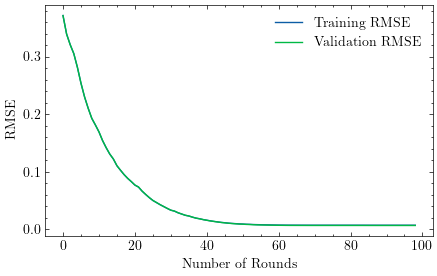

In [49]:
print(st_model.evals_result_.keys())
with plt.style.context('science'):
    plt.plot(st_model.evals_result_['validation_0']['rmse'], label='Training RMSE')
    plt.plot(st_model.evals_result_['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Number of Rounds')
    plt.ylabel('RMSE')
    #plt.title('XGBoost Learning Curve trained on synthetic data')
    plt.legend()
    plt.gcf().set_size_inches(5,3)
    plt.savefig(os.path.join(save_directory, "XGBoost_Loss_synthetic.pdf"), dpi=300)
    plt.show()

In [50]:
num_rounds_train = len(model.evals_result_['validation_0']['rmse'])
num_rounds_val = len(model.evals_result_['validation_1']['rmse'])

# Create a vector for the rounds; assuming both have the same length
rounds = list(range(1, num_rounds_train + 1))

In [51]:
joblib.dump(st_model, 'Ronqueira_synthetic_model.joblib')

['Ronqueira_synthetic_model.joblib']

Metrics on train

In [52]:
y_pred_df2 = pd.DataFrame(data=st_y_pred, columns=y_test2.columns)
y_pred_df_no_real = pd.DataFrame(data=st_y_pred_no_real, columns=y_test.columns)

#inverse_pred2 = pd.DataFrame(scaler_out2.inverse_transform(y_pred_df2[st_out_col]), columns=st_out_col)
#inverse_pred_no_real = pd.DataFrame(scaler_out2.inverse_transform(y_pred_df_no_real[out_col]), columns=out_col)
inverse_pred2 = pd.DataFrame(scaler_out.inverse_transform(y_pred_df2[st_out_col]), columns=st_out_col)
inverse_pred_no_real = pd.DataFrame(scaler_out.inverse_transform(y_pred_df_no_real[out_col]), columns=out_col)

In [53]:
rmse_dict_real = {}

for column in y_test.columns:
    rmse_real = np.sqrt(mean_squared_error(y_test[column],inverse_pred_no_real[column]))
    rmse_dict_real[column] = rmse_real

mse_dict_real = {}
for column in y_test.columns:
    mse_real = mean_squared_error(y_test[column],inverse_pred_no_real[column])
    mse_dict_real[column] = mse_real
    
r2_dict_real = {}
for column in y_test.columns:
    r2_real = r2_score(y_test[column],inverse_pred_no_real[column])
    r2_dict_real[column] = r2_real
    
    
    
metrics_xgboost_real = pd.DataFrame({'RMSE': rmse_dict_real, 'MSE': mse_dict_real, 'R2': r2_dict_real})

print(metrics_xgboost_real)

                  RMSE           MSE        R2
pump_kw_alb   3.989313  1.591462e+01  0.991004
pump_kw_alb2  0.420262  1.766201e-01  0.999837
pump_kw_trv   1.583611  2.507824e+00  0.993795
pump_kw_oc    0.517774  2.680899e-01  0.999870
pump_kw_spd   3.459334  1.196699e+01  0.990314
pump_kw_grj   1.423620  2.026694e+00  0.990949
Δ_b_Res_ALB   0.000010  9.101718e-11  0.942038
Δ_b_Res_TRV   0.000008  6.651651e-11  0.964159
Δ_b_Res_OC    0.000060  3.617431e-09  0.172019
Δ_b_Res_SPD   0.000011  1.162268e-10  0.970343
Δ_b_Res_AVL   0.000008  5.722373e-11  0.936368
Δ_b_Res_ESP   0.000007  5.308000e-11  0.776111


In [54]:
st_y_pred_no_real_s = st_model.predict(x_test_norm_real) # prediction no real mas scalled com o scaler sintético

### synthetic predicting

In [55]:
del valve_value

NameError: name 'valve_value' is not defined

In [56]:
tank_final2 = pd.DataFrame()
potencia2 = pd.DataFrame()
tank_02 = pd.DataFrame()

final2 = pd.DataFrame(0,index=[0], columns=[tank_columns]) # inicializar dataframe com indice
power2 = pd.DataFrame(0,index=[0], columns=[pump_columns]) 
flag_first_time2=True
Valvula2 = [0]
for i in range(len(july_10['dtime'])):
    dtime = july_10['dtime_sec'][i]
    if july_10['Time_only'][i] == datetime.time(0, 0) and flag_first_time2:
        #tank_0 = init_level  # dataframe niveis iniciais de cada tanque
        final2 = init_level.copy()
        power2 = pd.DataFrame(july_10[pump_columns].iloc[[0]], index=[0], columns=pump_columns)
        flag_first_time2=False
    else:
        
        tank_02 = tank_final2.iloc[[-1]]
        new_row2=new_x.iloc[[i]]
        x_test_cross2 = pd.concat([tank_02.reset_index(drop=True), new_row2.reset_index(drop=True)], axis=1)

        # Definição valvula
        for t in range(len(x_test_cross2)):
            if x_test_cross2.loc[t, "b_Res_ESP"] < 2.25:
                valve_value = 1  # Open
            elif x_test_cross2.loc[t, "b_Res_ESP"] > 2.7:
                valve_value = 0  # Close
            elif x_test_cross2.loc[t, "b_Res_ALB"] < 2.54:
                valve_value = 0  # Close
            else:
                valve_value = Valvula2[-1]
                
            
            x_test_cross2['Valve'] = valve_value
            
            Valvula2.append(valve_value)
        
        # Normalization
        x_normalizado2 = x_test_cross2.copy()
        #x_normalizado2[columns_to_normalize_st] = scaler_in2.transform(x_normalizado2[columns_to_normalize_st])
        x_normalizado2[columns_to_normalize_st] = scaler_in.transform(x_normalizado2[columns_to_normalize_st])

        # Prediction
        y_pred_cross2 = st_model.predict(x_normalizado2)
        y_pred_cross_df2 = pd.DataFrame(data=y_pred_cross2, columns=[cross_out_col])
        
        # Desnormalizar
        #y_pred_cross_un2 = pd.DataFrame(scaler_out2.inverse_transform(y_pred_cross_df2[cross_out_col]), columns=[cross_out_col])
        y_pred_cross_un2 = pd.DataFrame(scaler_out.inverse_transform(y_pred_cross_df2[cross_out_col]), columns=[cross_out_col])

        # Integration
        for j in tank_columns:
            final2[j] = (y_pred_cross_un2['Δ_' + j].values * dtime) + tank_02[j].values[0]
        for h in pump_columns:
            power2[h] = y_pred_cross_un2[h]

    tank_final2 = pd.concat([tank_final2, final2], ignore_index=True)
    potencia2 = pd.concat([potencia2, power2], ignore_index=True)

print('inIt level', init_level)
print('tank_final2', tank_final2.head())    
print(tank_final2.shape)
print(potencia2.shape)


NameError: name 'tank_columns' is not defined

Plots

In [85]:
#tank_final2=tank_final2[:-1]
#time_list_hours=time_list_hours[:-1]

In [86]:
#time_list_hours=time_list_hours[:-1]

In [57]:
time_hour = july_10['Time']

for m in tank_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10['final_' + str(m)], label='Real')
        plt.plot(time_list_hours, tank_final2[m], label='Predicted\n(based on epanet)')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Tank level [m]')
        plt.title('{} level error propagation'.format(m))
        plt.savefig(os.path.join(save_directory, 'ron_synthetic_' + clean_column_name(m) + " level error propagation.pdf"), dpi=300)
        plt.show()

NameError: name 'july_10' is not defined

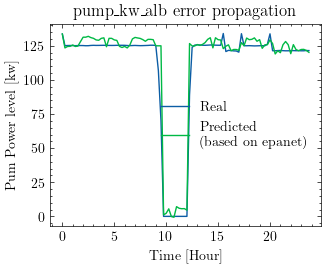

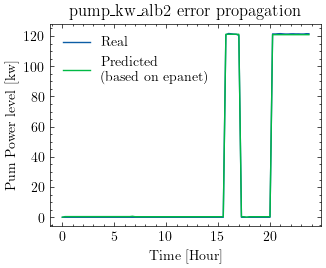

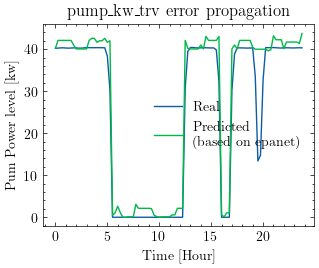

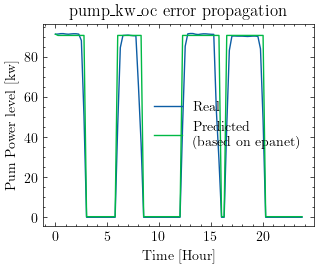

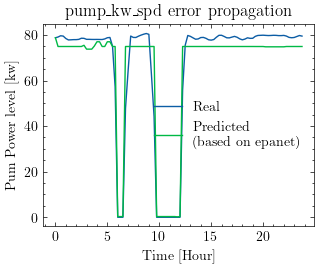

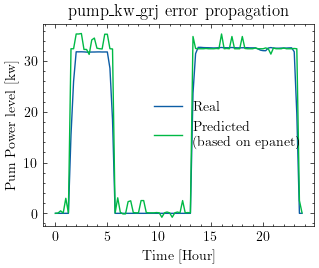

In [88]:
for j in pump_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10[j], label='Real')
        plt.plot(time_list_hours, potencia2[j], label='Predicted\n(based on epanet)')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Pum Power level [kw]')
        plt.title('{}  error propagation'.format(j))
        plt.savefig(os.path.join(save_directory, 'ron_synthetic_' + clean_column_name(j) + " error propagation.pdf"), dpi=300)

        plt.show()

In [89]:
july_10_na=july_10.dropna()
tank_final2=tank_final2.dropna()

In [90]:
r2_dict3_pumps = {}
rmse_dict3_pumps = {}
mse_dict3_pumps = {}

for column in pump_columns:
    r23_p = r2_score(july_10[column],potencia2[column])
    rmse3_p = np.sqrt(mean_squared_error(july_10[column], potencia2[column]))
    mse3_p = mean_squared_error(july_10[column], potencia2[column])
    
    r2_dict3_pumps[column] = r23_p
    rmse_dict3_pumps[column] = rmse3_p
    mse_dict3_pumps[column] = mse3_p

# Tanks
r2_dict3_tanks = {}
rmse_dict3_tanks = {}
mse_dict3_tanks = {}
for column in tank_columns:
    r23_t = r2_score(july_10_nan['final_'+str(column)], tank_final2[column])
    rmse3_t = np.sqrt(mean_squared_error(july_10_nan['final_'+str(column)], tank_final2[column]))
    mse3_t = mean_squared_error(july_10_nan['final_'+str(column)], tank_final2[column])
    
    r2_dict3_tanks[column] = r23_t
    rmse_dict3_tanks[column] = rmse3_t
    mse_dict3_tanks[column] = mse3_t

# Create separate DataFrames for pumps and tanks
metrics_cross_pumps2 = pd.DataFrame({'RMSE': rmse_dict3_pumps, 'MSE': mse_dict3_pumps, 'R2': r2_dict3_pumps })
metrics_cross_tanks2 = pd.DataFrame({'RMSE': rmse_dict3_tanks, 'MSE': mse_dict3_tanks, 'R2': r2_dict3_tanks })

print(metrics_cross_pumps2)
print(metrics_cross_tanks2)

                   RMSE         MSE        R2
pump_kw_alb    8.024845   64.398139  0.956311
pump_kw_alb2   0.427377    0.182651  0.999927
pump_kw_trv    4.697116   22.062901  0.936648
pump_kw_oc    13.879467  192.639598  0.896606
pump_kw_spd    6.331038   40.082048  0.945299
pump_kw_grj    3.205536   10.275462  0.957404
               RMSE       MSE        R2
b_Res_ALB  0.114844  0.013189  0.931483
b_Res_TRV  0.048375  0.002340  0.969511
b_Res_OC   0.645239  0.416333 -8.502702
b_Res_SPD  0.258848  0.067002  0.164695
b_Res_AVL  0.137403  0.018880  0.753953
b_Res_ESP  0.030598  0.000936  0.940385


In [91]:
global_pumps_synth = metrics_cross_pumps2.mean()
global_tanks_synth= metrics_cross_tanks2.mean()
print('Global for pumps \n', global_pumps_synth)
print('Global for tanks\n ', global_tanks_synth)

Global for pumps 
 RMSE     6.094230
MSE     54.940133
R2       0.948699
dtype: float64
Global for tanks
  RMSE    0.205884
MSE     0.086447
R2     -0.790446
dtype: float64


# Transfer learning

Agora vai retreinar nos dados reais

In [58]:
re_data = pd.read_csv(r'real_samples.csv', index_col=False)

In [59]:
re_data.columns

Index(['Unnamed: 0', 'Time', 'junction_b'15'', 'junction_b'20'',
       'junction_b'18'', 'pumps_b_p_grj', 'junction_b'11'', 'junction_b'12'',
       'junction_b'10'', 'Pump_ALB_total', 'pumps_b_p_alb', 'pumps_b_p_alb2',
       'pumps_b_p_trv', 'pumps_b_p_oc', 'pumps_b_p_spd', 'b_Res_ALB',
       'Res_Alb2', 'b_Res_OC', 'Res_Arr2', 'b_Res_AVL', 'b_Res_ESP',
       'Res_Esp2', 'b_Res_SPD', 'Res_SPD2', 'b_Res_TRV', 'Res_Tra2',
       'junction_b'2'', 'junction_b'6'', 'pump_state_b_p_grj',
       'pump_state_b_p_alb', 'pump_state_b_p_alb2', 'pump_state_b_p_trv',
       'pump_state_b_p_oc', 'pump_state_b_p_spd', 'pump_kw_alb',
       'pump_kw_alb2', 'pump_kw_trv', 'pump_kw_oc', 'pump_kw_spd',
       'pump_kw_grj', 'Valve', 'dtime', 'Δ_b_Res_ALB', 'Δ_b_Res_OC',
       'Δ_b_Res_AVL', 'Δ_b_Res_ESP', 'Δ_b_Res_SPD', 'Δ_b_Res_TRV'],
      dtype='object')

In [60]:
re_in_col = [
    "b_Res_ALB", "b_Res_TRV" , "b_Res_OC", "b_Res_SPD", "b_Res_AVL", "b_Res_ESP",
    "junction_b'10'", "junction_b'11'", "junction_b'12'", "junction_b'15'", "junction_b'18'", "junction_b'20'",
    "junction_b'2'", "junction_b'6'", "pump_state_b_p_alb", "pump_state_b_p_alb2", "pump_state_b_p_trv", "pump_state_b_p_oc", 
    "pump_state_b_p_spd", "pump_state_b_p_grj", "Valve"
]
X_real = re_data.loc[:, re_in_col]
re_out_col = ["pump_kw_alb", "pump_kw_alb2", "pump_kw_trv", "pump_kw_oc", "pump_kw_spd", "pump_kw_grj",
           "Δ_b_Res_ALB", "Δ_b_Res_TRV", "Δ_b_Res_OC", "Δ_b_Res_SPD", "Δ_b_Res_AVL", "Δ_b_Res_ESP"
]
y_real = re_data.loc[:, re_out_col]

In [61]:
X_temp3, X_test3, y_temp3, y_test3 = train_test_split(X_real, y_real, test_size=0.1, random_state=42)
X_train3, X_val3, y_train3, y_val3 = train_test_split(X_temp3, y_temp3, test_size=0.2, random_state=42)

In [62]:
X_train_norm3=X_train3.copy()
y_train_norm3=y_train3.copy()
x_test_norm3=X_test3.copy()
y_test_norm3=y_test3.copy()
x_val_norm3=X_val3.copy()
y_val_norm3=y_val3.copy()


# Specify the columns you want to normalize
columns_to_normalize13 = [col for col in re_in_col if not col.startswith("pump_state_") | col.startswith("Valv")]

# For train
#X_train_norm3[columns_to_normalize13] = scaler_in2.transform(X_train3[columns_to_normalize13])
#y_train_norm3[re_out_col] = scaler_out2.transform(y_train3[re_out_col])
X_train_norm3[columns_to_normalize13] = scaler_in.transform(X_train3[columns_to_normalize13])
y_train_norm3[re_out_col] = scaler_out.transform(y_train3[re_out_col])
# For test
#x_test_norm3[columns_to_normalize13] = scaler_in2.transform(X_test3[columns_to_normalize13])
#y_test_norm3[re_out_col] = scaler_out2.transform(y_test3[re_out_col])
x_test_norm3[columns_to_normalize13] = scaler_in.transform(X_test3[columns_to_normalize13])
y_test_norm3[re_out_col] = scaler_out.transform(y_test3[re_out_col])
# For val
#x_val_norm3[columns_to_normalize13] = scaler_in2.transform(X_val3[columns_to_normalize13])
#y_val_norm3[re_out_col] = scaler_out2.transform(y_val3[re_out_col])
x_val_norm3[columns_to_normalize13] = scaler_in.transform(X_val3[columns_to_normalize13])
y_val_norm3[re_out_col] = scaler_out.transform(y_val3[re_out_col])

In [63]:
loaded_synthetic_model = joblib.load('Ronqueira_synthetic_model.joblib')

Fitting the model

In [64]:
#synthetic model but now fit in real data
booster_source = loaded_synthetic_model.get_booster()
model_synthetic_scaler = xgb.XGBRegressor(learning_rate=0.05,max_depth=20,n_estimators=250,eval_metric="rmse")

model_synthetic_scaler.fit(X_train_norm3, y_train_norm3, eval_set=[(X_train_norm3, y_train_norm3),(x_val_norm3,y_val_norm3)],early_stopping_rounds=10,xgb_model=booster_source)

re_st_ypred = model_synthetic_scaler.predict(x_test_norm_real) # prediction no x real mas normalizado com o scaler 2!!

c:\Users\LENOVO\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:0.13799	validation_1-rmse:0.13767
[1]	validation_0-rmse:0.13194	validation_1-rmse:0.13172
[2]	validation_0-rmse:0.12636	validation_1-rmse:0.12622
[3]	validation_0-rmse:0.12102	validation_1-rmse:0.12098
[4]	validation_0-rmse:0.11595	validation_1-rmse:0.11606
[5]	validation_0-rmse:0.11115	validation_1-rmse:0.11141
[6]	validation_0-rmse:0.10691	validation_1-rmse:0.10744
[7]	validation_0-rmse:0.10256	validation_1-rmse:0.10325
[8]	validation_0-rmse:0.09857	validation_1-rmse:0.09939
[9]	validation_0-rmse:0.09497	validation_1-rmse:0.09607
[10]	validation_0-rmse:0.09147	validation_1-rmse:0.09270
[11]	validation_0-rmse:0.08815	validation_1-rmse:0.08953
[12]	validation_0-rmse:0.08489	validation_1-rmse:0.08646
[13]	validation_0-rmse:0.08199	validation_1-rmse:0.08369
[14]	validation_0-rmse:0.07911	validation_1-rmse:0.08102
[15]	validation_0-rmse:0.07653	validation_1-rmse:0.07861
[16]	validation_0-rmse:0.07396	validation_1-rmse:0.07625
[17]	validation_0-rmse:0.07161	validation

dict_keys(['validation_0', 'validation_1'])


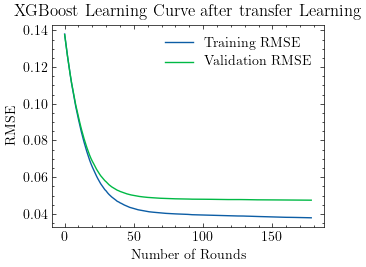

In [65]:
print(model_synthetic_scaler.evals_result_.keys())
with plt.style.context('science'):
    plt.plot(model_synthetic_scaler.evals_result_['validation_0']['rmse'], label='Training RMSE')
    plt.plot(model_synthetic_scaler.evals_result_['validation_1']['rmse'], label='Validation RMSE')
    plt.xlabel('Number of Rounds')
    plt.ylabel('RMSE')
    plt.title('XGBoost Learning Curve after transfer Learning')
    plt.legend()
    plt.savefig(os.path.join(save_directory, "XGBoost_Loss_after_TL.pdf"), dpi=300)
    plt.show()

In [66]:
joblib.dump(model_synthetic_scaler, 'Ronqueira_transfer_model.joblib')

['Ronqueira_transfer_model.joblib']

In [67]:
re_st_ypred = model_synthetic_scaler.predict(x_test_norm) 

In [69]:
re_st_ypred_df = pd.DataFrame(data=re_st_ypred, columns=y_test.columns)
#inverse_pred3 = pd.DataFrame(scaler_out2.inverse_transform(re_st_ypred_df[re_out_col]), columns=re_out_col)
inverse_pred3 = pd.DataFrame(scaler_out.inverse_transform(re_st_ypred_df[re_out_col]), columns=re_out_col)

rmse_dict4 = {}
for column in y_test.columns:
    rmse4 = np.sqrt(mean_squared_error(y_test[column],inverse_pred3[column]))
    rmse_dict4[column] = rmse4

mse_dict4 = {}
for column in y_test.columns:
    mse4 = mean_squared_error(y_test[column],inverse_pred3[column])
    mse_dict4[column] = mse4
    
r2_dict4 = {}
for column in y_test.columns:
    r24 = r2_score(y_test[column],inverse_pred3[column])
    r2_dict4[column] = r24
    
    
    
metrics_xgboost4 = pd.DataFrame({'RMSE': rmse_dict4, 'MSE': mse_dict4, 'R2': r2_dict4})

print('Metrics after transfer Learning \n',metrics_xgboost4)


Metrics after transfer Learning 
                   RMSE           MSE        R2
pump_kw_alb   1.817211  3.302255e+00  0.998133
pump_kw_alb2  0.183404  3.363690e-02  0.999969
pump_kw_trv   0.533728  2.848655e-01  0.999295
pump_kw_oc    0.517222  2.675191e-01  0.999870
pump_kw_spd   0.951772  9.058693e-01  0.999267
pump_kw_grj   0.597226  3.566785e-01  0.998407
Δ_b_Res_ALB   0.000016  2.647747e-10  0.831384
Δ_b_Res_TRV   0.000007  5.233758e-11  0.971799
Δ_b_Res_OC    0.000046  2.132982e-09  0.511789
Δ_b_Res_SPD   0.000005  2.665821e-11  0.993198
Δ_b_Res_AVL   0.000007  4.788125e-11  0.946757
Δ_b_Res_ESP   0.000010  9.499748e-11  0.599305


### Prediction (cross test)

In [70]:
tank_final3 = pd.DataFrame()
potencia3 = pd.DataFrame()
tank_03 = pd.DataFrame()

final3 = pd.DataFrame(0,index=[0], columns=[tank_columns]) # inicializar dataframe com indice
power3 = pd.DataFrame(0,index=[0], columns=[pump_columns]) 
flag_first_time3 = True
Valvula3 = [0]
for i in range(len(july_10['dtime'])):
    dtime = july_10['dtime_sec'][i]
    if july_10['Time_only'][i] == datetime.time(0, 0) and flag_first_time3:
        flag_first_time3=False
        #tank_0 = init_level  # dataframe niveis iniciais de cada tanque
        final3 = init_level.copy()
        power3 = pd.DataFrame(july_10[pump_columns].iloc[[0]], index=[0], columns=pump_columns)
    else:
        
        tank_03 = tank_final3.iloc[[-1]]
        new_row3=new_x.iloc[[i]]
        x_test_cross3 = pd.concat([tank_03.reset_index(drop=True), new_row3.reset_index(drop=True)], axis=1)
         # Definição valvula
        for t in range(len(x_test_cross3)):
            if x_test_cross3.loc[t, "b_Res_ESP"] < 2.25:
                valve_value = 1  # Open
            elif x_test_cross3.loc[t, "b_Res_ESP"] > 2.7:
                valve_value = 0  # Close
            elif x_test_cross3.loc[t, "b_Res_ALB"] < 2.54:
                valve_value = 0  # Close
            else:
                valve_value = Valvula3[-1]
                
            
            x_test_cross3['Valve'] = valve_value
            
            Valvula3.append(valve_value)
        
        # Normalization
        x_normalizado3 = x_test_cross3.copy()
        #x_normalizado3[columns_to_normalize_st] = scaler_in2.transform(x_normalizado3[columns_to_normalize_st])
        x_normalizado3[columns_to_normalize_st] = scaler_in.transform(x_normalizado3[columns_to_normalize_st])

        # Prediction
        y_pred_cross3 = model_synthetic_scaler.predict(x_normalizado3)
        y_pred_cross_df3 = pd.DataFrame(data=y_pred_cross3, columns=[cross_out_col])
        
        # Desnormalizar
        #y_pred_cross_un3 = pd.DataFrame(scaler_out2.inverse_transform(y_pred_cross_df3[cross_out_col]), columns=[cross_out_col])
        y_pred_cross_un3 = pd.DataFrame(scaler_out.inverse_transform(y_pred_cross_df3[cross_out_col]), columns=[cross_out_col])

        # Integration
        for j in tank_columns:
            final3[j] = (y_pred_cross_un3['Δ_' + j].values * dtime) + tank_03[j].values[0]
        for h in pump_columns:
            power3[h] = y_pred_cross_un3[h]

    tank_final3 = pd.concat([tank_final3, final3], ignore_index=True)
    potencia3 = pd.concat([potencia3, power3], ignore_index=True)

#print('inti level', init_level)
#print('tank_final3', tank_final3.head())        
#print(tank_final3.shape)
#print(potencia3.shape)


NameError: name 'tank_columns' is not defined

Plots

In [71]:
time_hour = july_10['Time']

NameError: name 'july_10' is not defined

In [72]:

time_list = list(range(0, 86401, 900))

time_list_hours = [t / 3600 for t in time_list]
time_list_hours = time_list_hours[:-1]

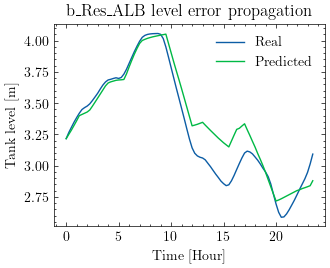

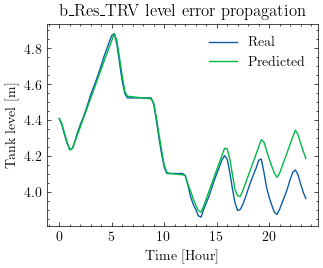

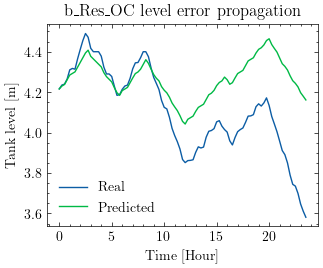

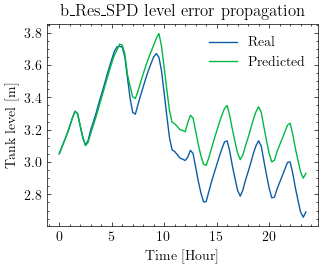

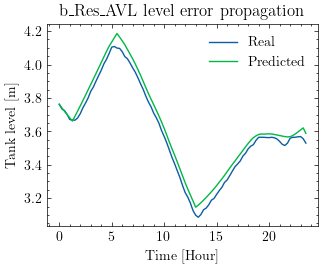

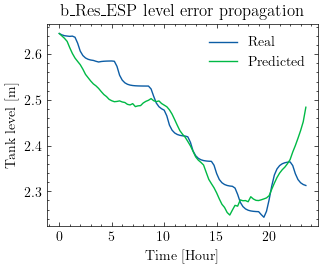

In [106]:
for m in tank_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10['final_' + str(m)], label='Real')
        plt.plot(time_list_hours, tank_final3[m], label='Predicted')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Tank level [m]')
        plt.title('{} level error propagation'.format(m))
        plt.savefig(os.path.join(save_directory, 'ron_tf_' + clean_column_name(m) + " level error propagation.pdf"), dpi=300)
        plt.show()

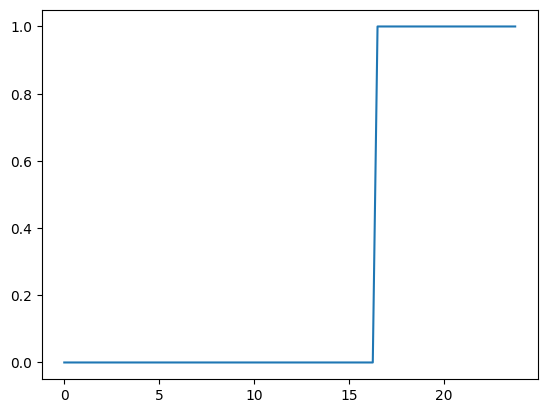

In [107]:
plt.plot(time_list_hours, Valvula3)
plt.show()

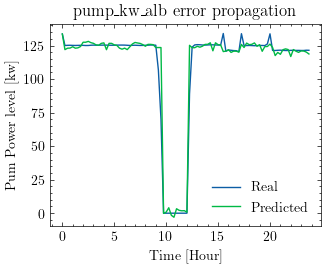

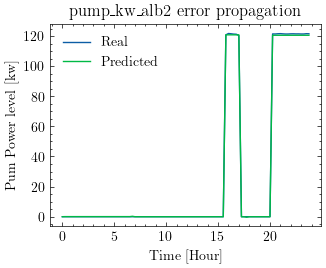

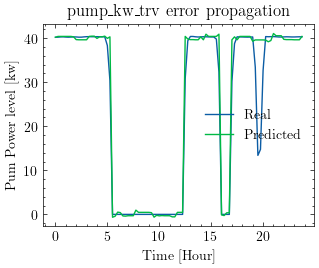

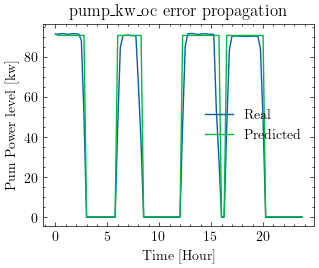

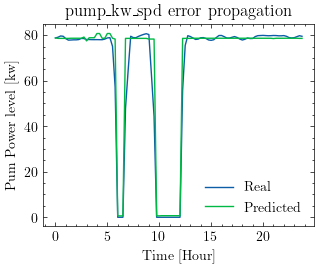

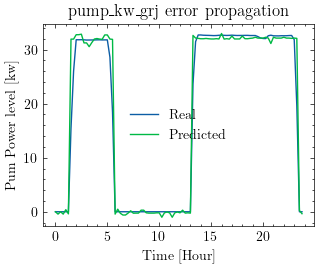

In [108]:
for j in pump_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10[j], label='Real')
        plt.plot(time_list_hours, potencia3[j], label='Predicted')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Pum Power level [kw]')
        plt.title('{}  error propagation'.format(j))
        plt.savefig(os.path.join(save_directory, 'ron_tf_' + clean_column_name(j) + " error propagation.pdf"), dpi=300)

        plt.show()

In [74]:
rounds_synthetic= list(range(0,len(st_model.evals_result_['validation_0']['rmse'])))

In [75]:
rounds_tf= list(range(len(rounds_synthetic), len(rounds_synthetic)+len( model_synthetic_scaler.evals_result_['validation_0']['rmse'])))

In [76]:
print(rounds_tf)
print(rounds_synthetic)

[99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28

In [77]:
tank_final3=tank_final3.dropna()

In [78]:
potencia3 = potencia3.drop(potencia3.index[-1])

IndexError: index -1 is out of bounds for axis 0 with size 0

In [79]:
# Create a single plot
save_directory = r'C:\Users\LENOVO\Desktop\Presentation'
with plt.style.context('science'):
    plt.style.use('dark_background')
    # Plotting synthetic data
    plt.plot(rounds_synthetic, st_model.evals_result_['validation_0']['rmse'], label='Synthetic Training RMSE')
    plt.plot(rounds_synthetic, st_model.evals_result_['validation_1']['rmse'], label='Synthetic Validation RMSE')
    
    # Plotting transfer learning data
    plt.plot(rounds_tf, model_synthetic_scaler.evals_result_['validation_0']['rmse'], label='Transfer Training RMSE')
    plt.plot(rounds_tf, model_synthetic_scaler.evals_result_['validation_1']['rmse'], label='Transfer Validation RMSE')

    plt.xlabel('Number of Rounds')
    plt.ylabel('RMSE')
    plt.title('XGBoost Learning Curve: Synthetic and Transfer Learning')
    plt.legend()
    
    plt.savefig(os.path.join(save_directory, "XGBoost_Loss_combined.png"), dpi=600)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\LENOVO\\Desktop\\Presentation\\XGBoost_Loss_combined.png'

Metrics on cross testing

In [115]:
r2_dicttf_pumps = {}
rmse_dicttf_pumps = {}
mse_dicttf_pumps = {}

for column in pump_columns:
    r2tf_p = r2_score(abs(potencia3[column]),july_10_na[column])
    rmsetf_p = np.sqrt(mean_squared_error(abs(potencia3[column]), july_10_na[column]))
    msetf_p = mean_squared_error(abs(potencia3[column]), july_10_na[column])
    
    r2_dicttf_pumps[column] = r2tf_p
    rmse_dicttf_pumps[column] = rmsetf_p
    mse_dicttf_pumps[column] = msetf_p

# Tanks
r2_dicttf_tanks = {}
rmse_dicttf_tanks = {}
mse_dicttf_tanks = {}
for column in tank_columns:
    r2tf_t = r2_score(tank_final3[column],july_10_na['final_'+str(column)])
    rmsetf_t = np.sqrt(mean_squared_error(tank_final3[column],july_10_na['final_'+str(column)]))
    msetf_t = mean_squared_error(tank_final3[column],july_10_na['final_'+str(column)])
    
    r2_dicttf_tanks[column] = r2tf_t
    rmse_dicttf_tanks[column] = rmsetf_t
    mse_dicttf_tanks[column] = msetf_t

# Create separate DataFrames for pumps and tanks
metrics_cross_pumps_tf = pd.DataFrame({'RMSE': rmse_dicttf_pumps, 'MSE': mse_dicttf_pumps, 'R2': r2_dicttf_pumps })
metrics_cross_tanks_tf = pd.DataFrame({'RMSE': rmse_dicttf_tanks, 'MSE': mse_dicttf_tanks, 'R2': r2_dicttf_tanks })

print(metrics_cross_pumps_tf)
print(metrics_cross_tanks_tf)

                   RMSE         MSE        R2
pump_kw_alb    7.298477   53.267769  0.962228
pump_kw_alb2   0.386129    0.149096  0.999938
pump_kw_trv    4.316145   18.629110  0.946977
pump_kw_oc    13.950176  194.607401  0.904201
pump_kw_spd    6.169357   38.060961  0.947108
pump_kw_grj    2.833171    8.026860  0.966569
               RMSE       MSE        R2
b_Res_ALB  0.154224  0.023785  0.848435
b_Res_TRV  0.094675  0.008963  0.845858
b_Res_OC   0.239101  0.057169 -5.104978
b_Res_SPD  0.167673  0.028114  0.416818
b_Res_AVL  0.045754  0.002093  0.972605
b_Res_ESP  0.046239  0.002138  0.823902


In [116]:
global_pumps_tf = metrics_cross_pumps_tf.mean()
global_tanks_tf= metrics_cross_tanks_tf.mean()
print('Global for pumps \n', global_pumps_tf)
print('Global for tanks\n ', global_tanks_tf)

Global for pumps 
 RMSE     5.825576
MSE     52.123533
R2       0.954504
dtype: float64
Global for tanks
  RMSE    0.124611
MSE     0.020377
R2     -0.199560
dtype: float64


In [117]:
potencia3.to_csv('potencia3.csv')

In [118]:
tank_final3.to_csv('tank_final_3.csv')

Graficos so do real (serie temporal)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


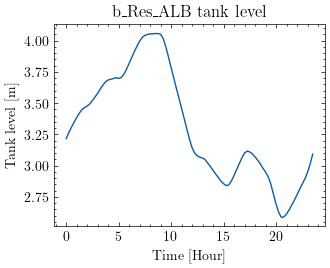

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


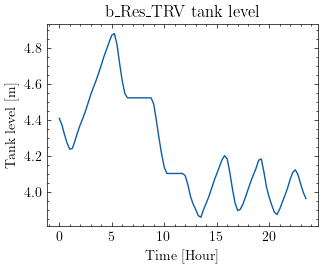

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


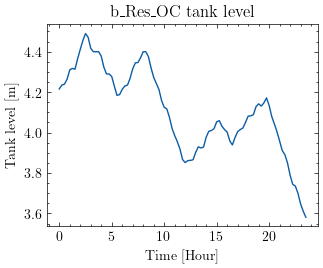

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


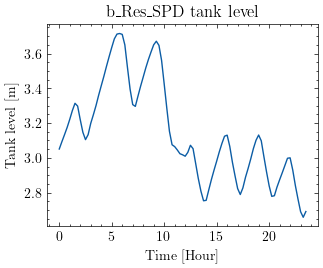

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


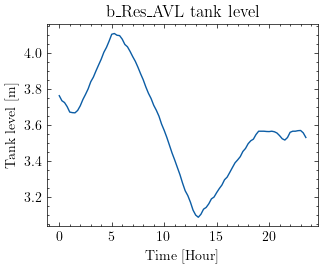

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


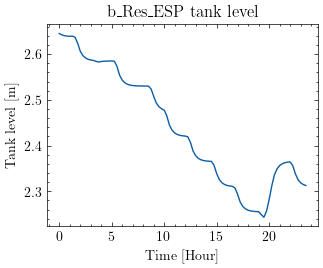

In [119]:
for m in tank_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10['final_' + str(m)])
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Tank level [m]')
        plt.title('{} tank level'.format(m))
        plt.savefig(os.path.join(save_directory, 'ron_' + clean_column_name(m) + "level.pdf"), dpi=300)
        plt.show()

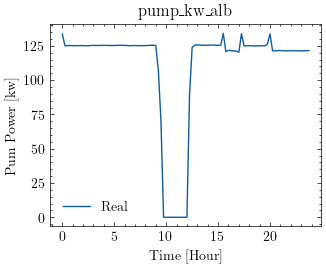

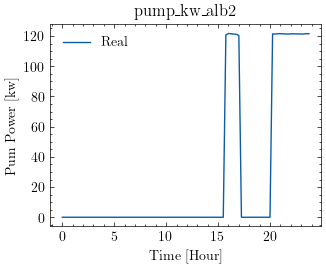

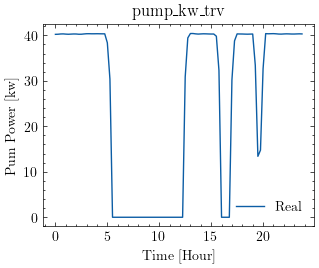

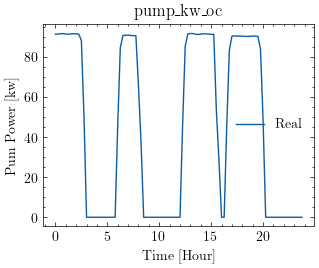

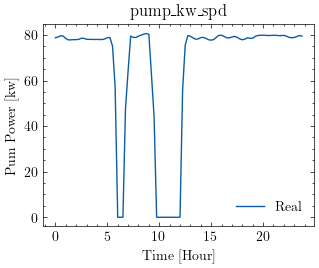

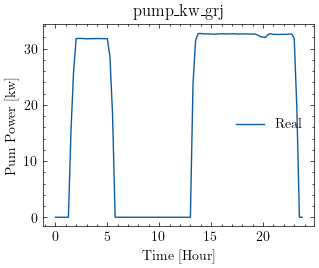

In [120]:
for j in pump_columns:
    with plt.style.context('science'):
        plt.figure()  # Create a new figure for each tank column
        plt.plot(time_list_hours, july_10[j], label='Real')
        plt.legend()
        plt.xlabel('Time [Hour]')
        plt.ylabel('Pum Power [kw]')
        plt.title('{}'.format(j))
        plt.savefig(os.path.join(save_directory, 'ron_' + clean_column_name(j) + ".pdf"), dpi=300)

        plt.show()